In [1]:
import math
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.core.algorithms import mode
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.python.keras.backend import concatenate
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.callbacks import History
#from series_to_supervised import series_to_supervised
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM
from keras.layers import Activation, Dense, Softmax, Dropout
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

In [2]:
import tensorflow  as tf
print(tf.__version__)

2.7.0


In [3]:
import keras
print(keras.__version__)

2.7.0


In [4]:
def rename (dataset_1,dataset_2,dataset_3):
    nn_1 = []
    lt_1 = list(dataset_1)
    for i in range(len(lt_1)):
        nn_1.append(lt_1[i]+'_1')
    dataset_1.columns = nn_1
    nn_2 = []
    lt_2 = list(dataset_2)
    for i in range(len(lt_2)):
        nn_2.append(lt_2[i]+'_2')
    dataset_2.columns = nn_2
    nn_3 = []
    lt_3 = list(dataset_3)
    for i in range(len(lt_3)):
        nn_3.append(lt_3[i]+'_3')
    dataset_3.columns = nn_3

In [5]:
def values (dataset):
    dataset['rl_wave'] = dataset['wave']
    dataset= dataset.drop(['wave'],axis=1)
    values = dataset.values #数值特征变量
    # convert series to supervised learning
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    # ensure all data is float
    values = values.astype('float32')
    # normalize features 歸一化
    ''''''
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    
    #reframed = series_to_supervised(values, 1, 1)
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[range(len(list(dataset)),len(list(dataset))*2)]], axis=1, inplace=True)
    
    # split into train and test sets
    values = reframed.values
    n_train_hours = int(len(values)*0.7)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:,:-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    return(train_X ,test_X,train_y,test_y)
    

In [6]:
#3成切割測試及驗證資料
def test_val(X,y):
    n_train_hours = int(len(X)/3)
    test_X = X[n_train_hours:, :]
    val_X = X[:n_train_hours, :]
    test_y = y[n_train_hours:]
    val_y = y[:n_train_hours]
    return(test_X,val_X,test_y,val_y)
    

資料夾位置

In [7]:
sector = 'D'

In [8]:
def star_end_wave(i):
    path = sector+':/openpose_data/揮手測試/'+i+'/揮手.txt'
    f = open(path, 'r')
    #print(f.read())
    l = f.read().split()
    f.close()
    return(int(l[0][5:]),int(l[11][4:]))

In [9]:
def star_end_c(i):
    path = sector+':/openpose_data/揮手測試/'+i+'/畫圈.txt'
    f = open(path, 'r')
    #print(f.read())
    l = f.read().split()
    f.close()
    return(int(l[0][5:]),int(l[11][4:]))

In [10]:
def star_end(i):
    path = sector+':/openpose_data/揮手測試/'+i+'/標記.txt'
    f = open(path, 'r')
    #print(f.read())
    l = f.read().split()
    f.close()
    return(int(l[0][5:]),int(l[11][4:]))

In [11]:
path = sector+':/openpose_data/揮手測試/畫圈_右手向右/標記.txt'
f = open(path, 'r')
#print(f.read())
l = f.read().split()
f.close()
print(int(l[0][5:]),int(l[11][4:]))

40 760


In [12]:
tra_X = []
tes_X = []
tra_y = []
tes_y = []
val_X = []
val_y = []
number = 1

In [13]:

sector = 'D'
fn = ['揮手_右手向右','揮手_右手向左','揮手_左手向右','揮手_左手向左']
for i in fn:
    dataset_0 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/揮手測試_all_標記.csv')#, header= None) 
    dataset_1 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/揮手測試_相關距離.csv') 
    dataset_2 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/揮手測試_移動距離_1.csv') 
    dataset_3 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/揮手測試_關節角度.csv') 
    dataset_4 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/揮手測試_關節向量.csv') 
    rename(dataset_1,dataset_2,dataset_3)
    locals()['dataset_'+str(i)] = pd.concat([dataset_0,dataset_1,dataset_2,dataset_3,dataset_4],axis= 1).dropna(axis=0)
    #locals()['dataset_'+str(i)] = pd.concat([dataset_0,dataset_1,dataset_2],axis= 1).dropna(axis=0)
    star , end = star_end(i)
    print(star , end)
    locals()['dataset_'+str(i)] = locals()['dataset_'+str(i)][star:end]
    locals()['train_X_'+str(i)] ,locals()['test_X_'+str(i)] ,locals()['train_y_'+str(i)] ,locals()['test_y_'+str(i)] = values(locals()['dataset_'+str(i)])#.iloc[:,75:]

    locals()['train_y_'+str(i)][locals()['train_y_'+str(i)] ==1] = number
    locals()['test_y_'+str(i)][locals()['test_y_'+str(i)] ==1] = number
    #將其中3成分成1成驗證資料及3成測試資料
    locals()['test_X_'+str(i)] ,locals()['val_X_'+str(i)] ,locals()['test_y_'+str(i)] ,locals()['val_y_'+str(i)] = test_val(locals()['test_X_'+str(i)], locals()['test_y_'+str(i)])
    print(number)
    number = number+1

    tra_X.append(locals()['train_X_'+str(i)])
    tes_X.append(locals()['test_X_'+str(i)])
    tra_y.append(locals()['train_y_'+str(i)])
    tes_y.append(locals()['test_y_'+str(i)])
    val_X.append(locals()['val_X_'+str(i)])
    val_y.append(locals()['val_y_'+str(i)])
    #print(len(locals()['train_X_'+str(i)]))
    #print(len(locals()['test_X_'+str(i)]))

50 1035
1
50 950
2
50 950
3
40 1040
4


C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.

In [14]:
fn = ['畫圈_右手向右','畫圈_右手向左','畫圈_左手向右','畫圈_左手向左']
for i in fn:
    dataset_0 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/畫圈測試_all_標記.csv')#, header= None) 
    dataset_1 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/畫圈測試_相關距離.csv') 
    dataset_2 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/畫圈測試_移動距離_1.csv') 
    dataset_3 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/畫圈測試_關節角度.csv') 
    dataset_4 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/畫圈測試_關節向量.csv') 
    rename(dataset_1,dataset_2,dataset_3)
    locals()['dataset_'+str(i)] = pd.concat([dataset_0,dataset_1,dataset_2,dataset_3,dataset_4],axis= 1).dropna(axis=0)
    #locals()['dataset_'+str(i)] = pd.concat([dataset_0,dataset_1,dataset_2],axis= 1).dropna(axis=0)
    star , end = star_end(i)
    print(star , end)
    locals()['dataset_'+str(i)] = locals()['dataset_'+str(i)][star:end]
    locals()['train_X_'+str(i)] ,locals()['test_X_'+str(i)] ,locals()['train_y_'+str(i)] ,locals()['test_y_'+str(i)] = values(locals()['dataset_'+str(i)])#.iloc[:,75:]

    locals()['train_y_'+str(i)][locals()['train_y_'+str(i)] ==1] = number
    locals()['test_y_'+str(i)][locals()['test_y_'+str(i)] ==1] = number
    #將其中3成分成1成驗證資料及3成測試資料
    locals()['test_X_'+str(i)] ,locals()['val_X_'+str(i)] ,locals()['test_y_'+str(i)] ,locals()['val_y_'+str(i)] = test_val(locals()['test_X_'+str(i)], locals()['test_y_'+str(i)])
    print(number)
    number = number+1

    tra_X.append(locals()['train_X_'+str(i)])
    tes_X.append(locals()['test_X_'+str(i)])
    tra_y.append(locals()['train_y_'+str(i)])
    tes_y.append(locals()['test_y_'+str(i)])
    val_X.append(locals()['val_X_'+str(i)])
    val_y.append(locals()['val_y_'+str(i)])
    
    #print(len(locals()['train_X_'+str(i)]))
    #print(len(locals()['test_X_'+str(i)]))

40 760
5
50 850
6
30 1000
7
30 850
8


C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.

In [15]:
fn = ['踢腳_右腳向右','踢腳_左腳向左']#'踢腳_右腳向右','踢腳_左腳向左','起立蹲下'
for i in fn:
    dataset_0 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/骨架資訊_all_標記.csv')#, header= None) 
    dataset_1 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/骨架測試_相關距離.csv') 
    dataset_2 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/骨架測試_移動距離.csv') 
    dataset_3 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/骨架測試_關節角度(左右手).csv') 
    dataset_4 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/骨架測試_關節向量(左右手).csv') 
    rename(dataset_1,dataset_2,dataset_3)
    locals()['dataset_'+str(i)] = pd.concat([dataset_0,dataset_1,dataset_2,dataset_3,dataset_4],axis= 1).dropna(axis=0)
    #locals()['dataset_'+str(i)] = pd.concat([dataset_0,dataset_1,dataset_2],axis= 1).dropna(axis=0)
    star , end = star_end(i)
    print(star , end)
    locals()['dataset_'+str(i)] = locals()['dataset_'+str(i)][star:end]
    locals()['train_X_'+str(i)] ,locals()['test_X_'+str(i)] ,locals()['train_y_'+str(i)] ,locals()['test_y_'+str(i)] = values(locals()['dataset_'+str(i)])#.iloc[:,75:]

    locals()['train_y_'+str(i)][locals()['train_y_'+str(i)] ==1] = number
    locals()['test_y_'+str(i)][locals()['test_y_'+str(i)] ==1] = number
    #將其中3成分成1成驗證資料及3成測試資料
    locals()['test_X_'+str(i)] ,locals()['val_X_'+str(i)] ,locals()['test_y_'+str(i)] ,locals()['val_y_'+str(i)] = test_val(locals()['test_X_'+str(i)], locals()['test_y_'+str(i)])
    print(number)
    number = number+1

    tra_X.append(locals()['train_X_'+str(i)])
    tes_X.append(locals()['test_X_'+str(i)])
    tra_y.append(locals()['train_y_'+str(i)])
    tes_y.append(locals()['test_y_'+str(i)])
    val_X.append(locals()['val_X_'+str(i)])
    val_y.append(locals()['val_y_'+str(i)])
    
    #print(len(locals()['train_X_'+str(i)]))
    #print(len(locals()['test_X_'+str(i)]))

C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


50 920
9
70 960
10


C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [16]:
fn = ['測試']#,'起立蹲下'
for i in fn:
    dataset_0 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/骨架資訊_all_標記.csv')#, header= None) 
    dataset_1 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/骨架測試_相關距離.csv') 
    dataset_2 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/骨架測試_移動距離.csv') 
    dataset_3 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/骨架測試_關節角度(左右手).csv') 
    dataset_4 = pd.read_csv(sector+':/openpose_data/揮手測試/'+i+'/骨架測試_關節向量(左右手).csv') 
    rename(dataset_1,dataset_2,dataset_3)
    locals()['dataset_'+str(i)] = pd.concat([dataset_0,dataset_1,dataset_2,dataset_3,dataset_4],axis= 1).dropna(axis=0)#
    #locals()['dataset_'+str(i)] = pd.concat([dataset_0,dataset_1,dataset_2],axis= 1).dropna(axis=0)
    star , end = star_end(i)
    print(star , end)
    locals()['dataset_'+str(i)] = locals()['dataset_'+str(i)][star:end]
    


95 1300


In [17]:
dataset = dataset_測試
values = dataset.values #数值特征变量
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# ensure all data is float
values = values.astype('float32')
# normalize features 歸一化
''''''
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[range(len(list(dataset)),len(list(dataset))*2)]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
test_test = values.reshape((values.shape[0], 1, values.shape[1]))
print('多動作測試資料')


多動作測試資料


C:\Users\DodoLu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexes\base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [18]:
train_X = tra_X[0]
test_X = tes_X[0]
train_y = tra_y[0]
test_y = tes_y[0]
vale_X = val_X[0]
vale_y = val_y[0]
for i in range(len(tra_X)-1):
    train_X = np.concatenate((train_X,tra_X[i+1]))
for i in range(len(tes_X)-1):
    test_X = np.concatenate((test_X,tes_X[i+1]))
for i in range(len(tra_y)-1):
    train_y = np.concatenate((train_y,tra_y[i+1]))
for i in range(len(tes_y)-1):
    test_y = np.concatenate((test_y,tes_y[i+1]))
    
for i in range(len(val_X)-1):
    vale_X = np.concatenate((vale_X,val_X[i+1]))
for i in range(len(val_y)-1):
    vale_y = np.concatenate((vale_y,val_y[i+1]))

In [19]:
'''
n = 3
train_X = tra_X[0+n]
test_X = tes_X[0+n]
train_y = tra_y[0+n]
test_y = tes_y[0+n]

train_X = np.concatenate((train_X,tra_X[4+n]))

test_X = np.concatenate((test_X,tes_X[4+n]))

train_y = np.concatenate((train_y,tra_y[4+n]))

test_y = np.concatenate((test_y,tes_y[4+n]))
'''

'\nn = 3\ntrain_X = tra_X[0+n]\ntest_X = tes_X[0+n]\ntrain_y = tra_y[0+n]\ntest_y = tes_y[0+n]\n\ntrain_X = np.concatenate((train_X,tra_X[4+n]))\n\ntest_X = np.concatenate((test_X,tes_X[4+n]))\n\ntrain_y = np.concatenate((train_y,tra_y[4+n]))\n\ntest_y = np.concatenate((test_y,tes_y[4+n]))\n'

In [20]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)
print(vale_X.shape)
print(vale_y.shape)

(6188, 1, 133)
(1772, 1, 133)
(6188,)
(1772,)
(885, 1, 133)
(885,)


超參數搜索

In [21]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as keras
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [22]:
# 準備資料集
X_train = train_X
y_train = train_y
X_test = test_X
y_test = test_y
X_vale = vale_X
y_vale = vale_y

In [23]:
from numpy.random import seed
seed(123)  # 设置全局随机种子
from tensorflow import random
random.set_seed(123)  # 设置 TensorFlow 随机数种子

In [25]:
# 建立 LSTM 模型
def create_model(neurons1=50, neurons2=50, neurons3=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(neurons1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neurons2, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(neurons3))
    model.add(Dropout(dropout_rate))
    #model.add(Dense(1))
    
    #optimizer = Adam(learning_rate=learning_rate)
    #model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.add(Dense(11, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [26]:
# 建立 GRU 模型
from keras.models import Sequential
from keras.layers import GRU, Dense
def GRU_model(neurons1=50, neurons2=50, neurons3=50, dropout_rate=0.2, learning_rate=0.001):
    # Define the model
    model = Sequential()
    model.add(GRU(units=neurons1, input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(Dropout(dropout_rate))
    #model.add(GRU(neurons2))#, return_sequences=True
    #model.add(Dropout(dropout_rate))
    #model.add(GRU(neurons3))
    #model.add(Dense(units=1, activation='sigmoid'))
    model.add(Dense(11, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  #LOSS = 'categorical_crossentropy'  /
    #對於多分類（multiclass classification）問題，通常使用的是 categorical_crossentropy 或 sparse_categorical_crossentropy 損失函數，
    # 因為它們能夠處理多個類別之間的相互關係。
    # 其中，categorical_crossentropy 用於 one-hot 編碼的多分類問題，
    # 而 sparse_categorical_crossentropy 用於整數標籤編碼的多分類問題。
    return model

    # Train the model
    #model.fit(x_train, y_train, batch_size=32, epochs=10)

    # Evaluate the model
    #loss, accuracy = model.evaluate(x_test, y_test)
    #print('Test loss:', loss)
    #print('Test accuracy:', accuracy)


In [27]:
# 定義要優化的超參數搜索範圍
neurons1 = [50, 100, 150, 200]
neurons2 = [50, 100, 150, 200]
neurons3 = [50, 100, 150, 200]
dropout_rates = [0.3] #[0.2, 0.3, 0.4]
learning_rates = [0.001] # [0.001, 0.01]
'''
# 定義超參數搜索範圍
param_grid = dict(neurons1=neurons1, neurons2=neurons2, neurons3=neurons3, dropout_rate=dropout_rates, learning_rate=learning_rates)

# 建立超參數搜索方法
model = KerasRegressor(build_fn=create_model, epochs=200, batch_size=64, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# 將 y_train / y_test  轉換為 one-hot 編碼 因應softmax需求

y_train_one_hot = to_categorical(y_train, num_classes=11)
y_test_one_hot = to_categorical(y_test, num_classes=11)

# 執行超參數搜索
grid_result = grid.fit(X_train, y_train_one_hot)

# 輸出最佳超參數
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

model = create_model(neurons1=grid_result.best_params_['neurons1'], neurons2=grid_result.best_params_['neurons2'], neurons3=grid_result.best_params_['neurons3'], dropout_rate=grid_result.best_params_['dropout_rate'], learning_rate=grid_result.best_params_['learning_rate'])
history = model.fit(X_train, y_train_one_hot, epochs=200, batch_size=64, validation_data=(X_test, y_test_one_hot), verbose=0)


# 使用最佳超參數訓練模型
#model = create_model(neurons1=grid_result.best_params_['neurons1'], neurons2=grid_result.best_params_['neurons2'], neurons3=grid_result.best_params_['neurons3'], dropout_rate=grid_result.best_params_['dropout_rate'], learning_rate=grid_result.best_params_['learning_rate'])
#history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=0)

# 繪製學習曲線
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# 使用最佳模
'''

'\n# 定義超參數搜索範圍\nparam_grid = dict(neurons1=neurons1, neurons2=neurons2, neurons3=neurons3, dropout_rate=dropout_rates, learning_rate=learning_rates)\n\n# 建立超參數搜索方法\nmodel = KerasRegressor(build_fn=create_model, epochs=200, batch_size=64, verbose=0)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)\n\n# 將 y_train / y_test  轉換為 one-hot 編碼 因應softmax需求\n\ny_train_one_hot = to_categorical(y_train, num_classes=11)\ny_test_one_hot = to_categorical(y_test, num_classes=11)\n\n# 執行超參數搜索\ngrid_result = grid.fit(X_train, y_train_one_hot)\n\n# 輸出最佳超參數\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\n\nmodel = create_model(neurons1=grid_result.best_params_[\'neurons1\'], neurons2=grid_result.best_params_[\'neurons2\'], neurons3=grid_result.best_params_[\'neurons3\'], dropout_rate=grid_result.best_params_[\'dropout_rate\'], learning_rate=grid_result.best_params_[\'learning_rate\'])\nhistory = model.fit(X_train, y_train_one_hot, epochs=200, batch_size

In [28]:
# 定義要優化的超參數搜索範圍
neurons1 = [100, 200, 300, 400, 500]
neurons2 = [100, 200, 300, 400, 500]
neurons3 = [100, 200, 300, 400, 500]
dropout_rates = [0.2, 0.3, 0.4]
learning_rates = [0.001, 0.01]
'''
# 定義超參數搜索範圍
param_grid = dict(neurons1=neurons1, neurons2=neurons2, neurons3=neurons3, dropout_rate=dropout_rates, learning_rate=learning_rates)

# 建立超參數搜索方法
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=64, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# 執行超參數搜索
grid_result = grid.fit(X_train, y_train)

# 輸出最佳超參數
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# 使用最佳超參數訓練模型
model = create_model(neurons1=grid_result.best_params_['neurons1'], neurons2=grid_result.best_params_['neurons2'], neurons3=grid_result.best_params_['neurons3'], dropout_rate=grid_result.best_params_['dropout_rate'], learning_rate=grid_result.best_params_['learning_rate'])
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=0)

# 繪製學習曲線
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# 使用最佳模
'''

'\n# 定義超參數搜索範圍\nparam_grid = dict(neurons1=neurons1, neurons2=neurons2, neurons3=neurons3, dropout_rate=dropout_rates, learning_rate=learning_rates)\n\n# 建立超參數搜索方法\nmodel = KerasRegressor(build_fn=create_model, epochs=50, batch_size=64, verbose=0)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)\n\n# 執行超參數搜索\ngrid_result = grid.fit(X_train, y_train)\n\n# 輸出最佳超參數\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\n\n# 使用最佳超參數訓練模型\nmodel = create_model(neurons1=grid_result.best_params_[\'neurons1\'], neurons2=grid_result.best_params_[\'neurons2\'], neurons3=grid_result.best_params_[\'neurons3\'], dropout_rate=grid_result.best_params_[\'dropout_rate\'], learning_rate=grid_result.best_params_[\'learning_rate\'])\nhistory = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=0)\n\n# 繪製學習曲線\nplt.plot(history.history[\'loss\'])\nplt.plot(history.history[\'val_loss\'])\nplt.title(\'Model loss\')\nplt.y

In [30]:
neurons1 = [50, 100, 150, 200]
neurons2 = [50, 100, 150, 200]
neurons3 = [50, 100, 150, 200]
dropout_rates = [0.2, 0.3, 0.4, 0.5]
learning_rates = [0.001, 0.01, 0.1]
#grid_result.best_params_#776min
'''
{'dropout_rate': 0.3,
 'learning_rate': 0.001,
 'neurons1': 100,
 'neurons2': 50,
 'neurons3': 200}
'''

"\n{'dropout_rate': 0.3,\n 'learning_rate': 0.001,\n 'neurons1': 100,\n 'neurons2': 50,\n 'neurons3': 200}\n"

In [31]:
neurons1 = [100, 200, 300] #softmax
neurons2 = [100, 200, 300]
neurons3 = [100, 200, 300]
dropout_rates = [0.3] #[0.2, 0.3, 0.4]
learning_rates = [0.001] # [0.001, 0.01]
'''
{'dropout_rate': 0.3,
 'learning_rate': 0.001,
 'neurons1': 100,
 'neurons2': 100,
 'neurons3': 100}
'''

"\n{'dropout_rate': 0.3,\n 'learning_rate': 0.001,\n 'neurons1': 100,\n 'neurons2': 100,\n 'neurons3': 100}\n"

In [33]:
neurons1 = [50, 100, 150, 200] #softmax
neurons2 = [50, 100, 150, 200]
neurons3 = [50, 100, 150, 200]
dropout_rates = [0.3] #[0.2, 0.3, 0.4]
learning_rates = [0.001] # [0.001, 0.01]
#grid_result.best_params_
'''
{'dropout_rate': 0.3,
 'learning_rate': 0.001,
 'neurons1': 150,
 'neurons2': 100,
 'neurons3': 50}
'''

"\n{'dropout_rate': 0.3,\n 'learning_rate': 0.001,\n 'neurons1': 150,\n 'neurons2': 100,\n 'neurons3': 50}\n"

In [34]:
# 定義要優化的超參數搜索範圍
neurons1 = [50, 100, 150, 200] #softmax
neurons2 = [50, 100, 150, 200]
neurons3 = [50, 100, 150, 200]
dropout_rates = [0.3] #[0.2, 0.3, 0.4]
learning_rates = [0.001] # [0.001, 0.01]

grid_result = {'dropout_rate': 0.3,
 'learning_rate': 0.001,
 'neurons1': 150,
 'neurons2': 100,
 'neurons3': 50}

In [35]:
# 將 y_train / y_test  轉換為 one-hot 編碼 因應softmax需求
y_train_one_hot = to_categorical(y_train, num_classes=11)
y_test_one_hot = to_categorical(y_test, num_classes=11)
y_vale_one_hot = to_categorical(y_vale, num_classes=11)

epochs = 50
#model = create_model(neurons1=100, neurons2=100, neurons3=100, dropout_rate=0.3, learning_rate=0.001)
model = create_model(neurons1=grid_result['neurons1'], neurons2=grid_result['neurons2'], neurons3=grid_result['neurons3'], dropout_rate=grid_result['dropout_rate'], learning_rate=grid_result['learning_rate'])
#history = model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=64, validation_data=(X_test, y_test_one_hot), verbose=2 )
history = model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=64, validation_data=(X_vale, y_vale_one_hot), verbose=2 )

Epoch 1/50
97/97 - 4s - loss: 1.8320 - accuracy: 0.5370 - val_loss: 1.6611 - val_accuracy: 0.5367 - 4s/epoch - 44ms/step
Epoch 2/50
97/97 - 0s - loss: 1.3535 - accuracy: 0.5921 - val_loss: 1.1321 - val_accuracy: 0.6316 - 487ms/epoch - 5ms/step
Epoch 3/50
97/97 - 0s - loss: 0.8308 - accuracy: 0.7474 - val_loss: 0.6617 - val_accuracy: 0.7616 - 496ms/epoch - 5ms/step
Epoch 4/50
97/97 - 0s - loss: 0.4923 - accuracy: 0.8594 - val_loss: 0.3693 - val_accuracy: 0.8972 - 481ms/epoch - 5ms/step
Epoch 5/50
97/97 - 0s - loss: 0.3551 - accuracy: 0.8974 - val_loss: 0.3113 - val_accuracy: 0.9017 - 487ms/epoch - 5ms/step
Epoch 6/50
97/97 - 0s - loss: 0.3047 - accuracy: 0.9118 - val_loss: 0.3172 - val_accuracy: 0.9006 - 487ms/epoch - 5ms/step
Epoch 7/50
97/97 - 1s - loss: 0.2768 - accuracy: 0.9184 - val_loss: 0.3035 - val_accuracy: 0.8825 - 505ms/epoch - 5ms/step
Epoch 8/50
97/97 - 0s - loss: 0.2478 - accuracy: 0.9208 - val_loss: 0.2372 - val_accuracy: 0.9153 - 488ms/epoch - 5ms/step
Epoch 9/50
97/97 -

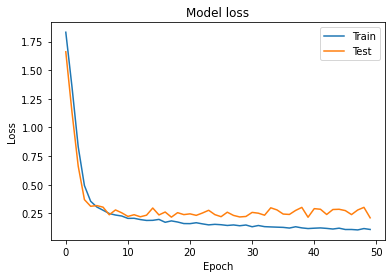

In [36]:
# 繪製學習曲線
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# 使用最佳模

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 50
分類器的準確率為： 0.9356659142212189
分類器的錯誤筆數為： 114
Test RMSE: 1.595


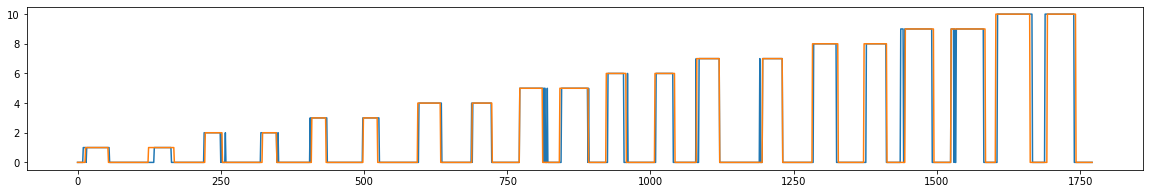

In [37]:
print(grid_result,'\n epochs:',epochs)
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

In [39]:
def fiveway(arr):
    # 将五个状态的元素分别设为 1、2、3、4、5
    arr_states = np.zeros((len(arr), 10), dtype=int)
    for i in range(1, 11):
        arr_states[:, i-1][arr == i] = 1
        
    # 使用卷积操作查找连续的五个相同的元素
    nb = 10
    kernel = np.ones(nb)
    result_states = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=0, arr=arr_states)


    # 将大于等于 5 的元素视为当前状态，其他元素视为 0
    result_states[result_states < nb] = 0
    idx = np.where(result_states >= nb)

    # 使用布尔索引找到对应的行和列
    row_idx = idx[0]
    col_idx = idx[1]

    # 将值为 5 的位置改成对应的列号
    result_states[row_idx, col_idx] = col_idx + 1

    # 将所有状态的结果相加得到总结果
    result = np.sum(result_states, axis=1)

    # 输出结果
    return(result)

## 5/2

### 儲存模型

In [41]:
#model.save('./model/lstm-Epoch50.h5')

### 導入模型

In [32]:
from tensorflow.keras.models import load_model

testmodel = load_model('./model/lstm-0502.h5')


{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 75
分類器的準確率為： 0.940910801656003
分類器的錯誤筆數為： 157
Test RMSE: 1.604


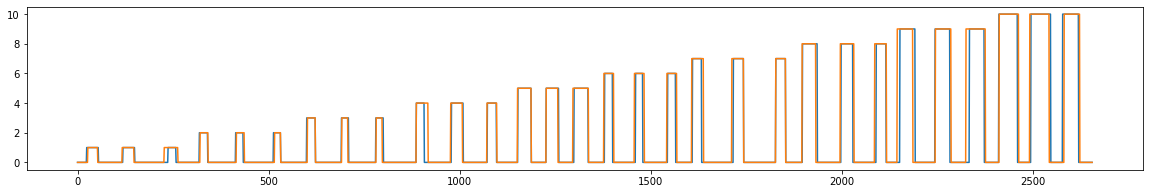

In [33]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = testmodel.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)
predicted_labels_5 = fiveway(predicted_labels)
y_test_5 = fiveway(y_test)

rmse = math.sqrt(mean_squared_error(predicted_labels_5, y_test_5))

# 計算分類器的準確率
accuracy = accuracy_score(y_test_5, predicted_labels_5)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test_5 != predicted_labels_5)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels_5)
plt.plot(y_test_5)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()
#show(y_test_5,predicted_labels_5)

[[1368   11   10   11    3    6    1    3    6   14    9]
 [  16  104    0    0    0    0    0    0    0    0    0]
 [   3    0   82    0    0    0    0    0    0    0    0]
 [   0    0    0   80    0    0    0    0    0    0    0]
 [  10    0    0    0  105    0    0    0    0    0    0]
 [   5    0    0    0    0  130    0    0    0    0    0]
 [  17    0    0    0    0    0   88    0    0    0    0]
 [  11    0    0    0    0    0    0  104    0    0    0]
 [  11    0    0    0    0    0    0    0  119    0    0]
 [  15    0    0    0    0    0    0    0    0  145    0]
 [   9    0    0    0    0    0    0    0    0    0  161]]


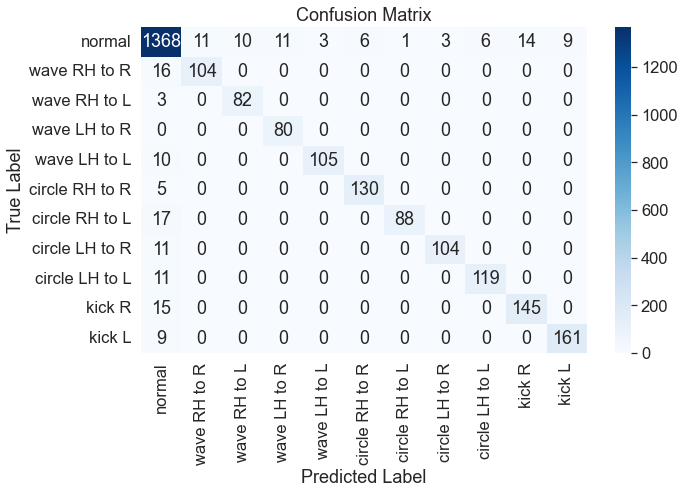

                precision    recall  f1-score      support
CLASS                                                     
normal           0.933788  0.948682  0.941176  1442.000000
wave RH to R     0.904348  0.866667  0.885106   120.000000
wave RH to L     0.891304  0.964706  0.926554    85.000000
wave LH to R     0.879121  1.000000  0.935673    80.000000
wave LH to L     0.972222  0.913043  0.941704   115.000000
circle RH to R   0.955882  0.962963  0.959410   135.000000
circle RH to L   0.988764  0.838095  0.907216   105.000000
circle LH to R   0.971963  0.904348  0.936937   115.000000
circle LH to L   0.952000  0.915385  0.933333   130.000000
kick R           0.911950  0.906250  0.909091   160.000000
kick L           0.947059  0.947059  0.947059   170.000000
accuracy         0.935642  0.935642  0.935642     0.935642
macro avg        0.937127  0.924291  0.929387  2657.000000
weighted avg     0.936490  0.935642  0.935495  2657.000000


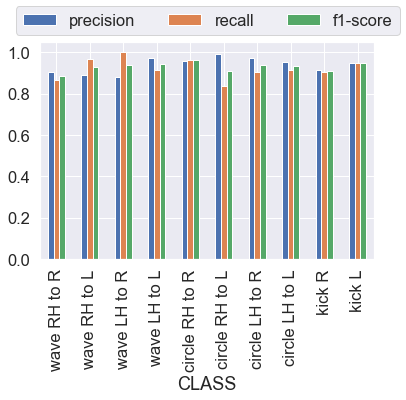

In [38]:
show(y_test, predicted_labels)

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 50
分類器的準確率為： 0.9424379232505643
分類器的錯誤筆數為： 102
Test RMSE: 1.562


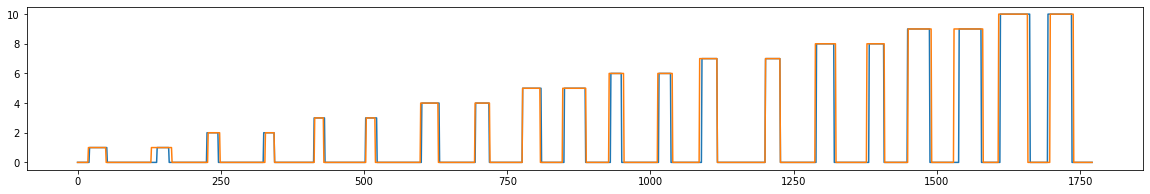

In [40]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)
predicted_labels_5 = fiveway(predicted_labels)
y_test_5 = fiveway(y_test)

rmse = math.sqrt(mean_squared_error(predicted_labels_5, y_test_5))

# 計算分類器的準確率
accuracy = accuracy_score(y_test_5, predicted_labels_5)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test_5 != predicted_labels_5)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels_5)
plt.plot(y_test_5)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()
#show(y_test_5,predicted_labels_5)

[[920   6   7   8   3   6   1   2   0   6   8]
 [ 16  69   0   0   0   0   0   0   0   0   0]
 [  2   0  53   0   0   0   0   0   0   0   0]
 [  0   0   0  50   0   0   0   0   0   0   0]
 [  4   0   0   0  71   0   0   0   0   0   0]
 [  4   0   0   0   0  86   0   0   0   0   0]
 [ 12   0   0   0   0   0  58   0   0   0   0]
 [  4   0   0   0   0   0   0  71   0   0   0]
 [ 10   0   0   0   0   0   0   0  75   0   0]
 [  9   0   0   0   0   0   0   0   0 101   0]
 [  6   0   0   0   0   0   0   0   0   0 104]]


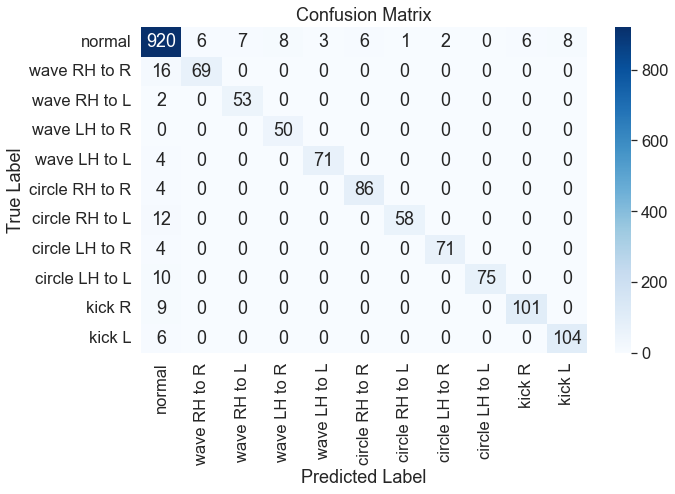

                precision    recall  f1-score      support
CLASS                                                     
normal           0.932118  0.951396  0.941658   967.000000
wave RH to R     0.920000  0.811765  0.862500    85.000000
wave RH to L     0.883333  0.963636  0.921739    55.000000
wave LH to R     0.862069  1.000000  0.925926    50.000000
wave LH to L     0.959459  0.946667  0.953020    75.000000
circle RH to R   0.934783  0.955556  0.945055    90.000000
circle RH to L   0.983051  0.828571  0.899225    70.000000
circle LH to R   0.972603  0.946667  0.959459    75.000000
circle LH to L   1.000000  0.882353  0.937500    85.000000
kick R           0.943925  0.918182  0.930876   110.000000
kick L           0.928571  0.945455  0.936937   110.000000
accuracy         0.935666  0.935666  0.935666     0.935666
macro avg        0.938174  0.922750  0.928536  1772.000000
weighted avg     0.936833  0.935666  0.935368  1772.000000


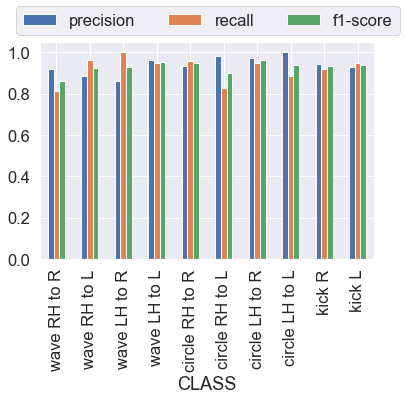

In [45]:
show(y_test, predicted_labels)

[[1665    7    7    9    2    2    0    0    4    7    9]
 [  17   76    0    0    0    0    0    0    0    0    0]
 [   4    0   54    0    0    0    0    0    0    0    0]
 [   0    0    0   53    0    0    0    0    0    0    0]
 [  14    0    0    0   74    0    0    0    0    0    0]
 [   5    0    0    0    0  103    0    0    0    0    0]
 [  17    0    0    0    0    0   61    0    0    0    0]
 [  11    0    0    0    0    0    0   77    0    0    0]
 [  11    0    0    0    0    0    0    0   92    0    0]
 [  22    0    0    0    0    0    0    0    0  111    0]
 [   9    0    0    0    0    0    0    0    0    0  134]]


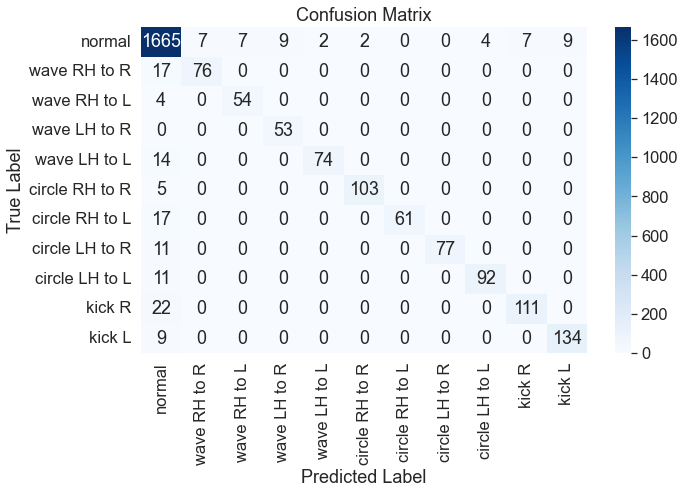

                precision    recall  f1-score      support
CLASS                                                     
normal           0.938028  0.972547  0.954976  1712.000000
wave RH to R     0.915663  0.817204  0.863636    93.000000
wave RH to L     0.885246  0.931034  0.907563    58.000000
wave LH to R     0.854839  1.000000  0.921739    53.000000
wave LH to L     0.973684  0.840909  0.902439    88.000000
circle RH to R   0.980952  0.953704  0.967136   108.000000
circle RH to L   1.000000  0.782051  0.877698    78.000000
circle LH to R   1.000000  0.875000  0.933333    88.000000
circle LH to L   0.958333  0.893204  0.924623   103.000000
kick R           0.940678  0.834586  0.884462   133.000000
kick L           0.937063  0.937063  0.937063   143.000000
accuracy         0.940911  0.940911  0.940911     0.940911
macro avg        0.944044  0.894300  0.915879  2657.000000
weighted avg     0.942099  0.940911  0.940179  2657.000000


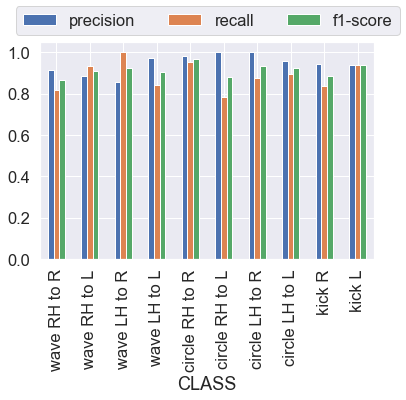

In [216]:
show(y_test_5,predicted_labels_5)

In [ ]:
# 使用最佳超參數訓練模型 #一般模型沒有使用softmax
'''
#model = create_model(neurons1=grid_result.best_params_['neurons1'], neurons2=grid_result.best_params_['neurons2'], neurons3=grid_result.best_params_['neurons3'], dropout_rate=grid_result.best_params_['dropout_rate'], learning_rate=grid_result.best_params_['learning_rate'])
model = create_model(neurons1=300, neurons2=200, neurons3=100, dropout_rate=0.3, learning_rate=0.001)

history = model.fit(X_train, y_train, epochs=1500, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# 繪製學習曲線
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
'''
# 使用最佳模

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            93600     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             30200     
                                                                 
 dropout_1 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 131,426
Trainable params: 131,426
Non-trai

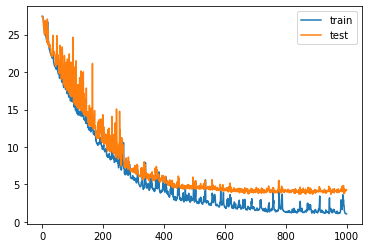

"\n# design network\nmodel = Sequential()\nmodel.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))\nmodel.add(Dense(1))\nmodel.compile(loss='mae', optimizer='adam')\n# fit network\nhistory = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)\n# plot history\nplt.plot(history.history['loss'], label='train')\nplt.plot(history.history['val_loss'], label='test')\nplt.legend()\nplt.show()\n"

In [18]:
# design network
'''
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))#,return_sequences=True,activation='relu'
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))#,return_sequences=True
model.add(Dropout(0.2))
model.add(LSTM(25,return_sequences=False))
model.add(Dense(1))# , activation='softmax'

model.summary()
model.compile(loss='MAE', optimizer='adam', metrics=['accuracy'])#loss='categorical_crossentropy'
#model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=288, validation_data=(test_X, test_y), verbose=2, shuffle=False)#False, validation_data=(X_test, y_test)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 評估模型的性能
#scores = model.evaluate(train_X, train_y, verbose=0)
#print("Model Accuracy: %.2f%%" % (scores[1]*100))
'''

'''
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
'''

 ['揮手_右手向右','揮手_右手向左','揮手_左手向右','揮手_左手向左']['畫圈_右手向右','畫圈_右手向左','畫圈_左手向右','畫圈_左手向左']['踢腳_右腳向右','踢腳_左腳向左']

In [42]:
def show_conf_mat(cm):  #可視化混淆矩陣
    # 定义类别数量
    num_classes = cm.shape[0]

    # 生成类别标签
    #labels = ["Class {}".format(i+1) for i in range(num_classes)]
    labels = ['normal','wave RH to R','wave RH to L','wave LH to R','wave LH to L','circle RH to R','circle RH to L','circle LH to R','circle LH to L','kick R','kick L']
    
    #
    plt.figure(figsize=(10, 6))
    
    # 使用Seaborn來可視化混淆矩陣
    sns.set(font_scale=1.5)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

    # 添加標題和軸標籤
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # 顯示可視化結果
    plt.show()

In [43]:
def showreport(report):  #可視化混淆矩陣數值
    # 将report转换为DataFrame格式
    df = pd.DataFrame(report).transpose()

    # 为DataFrame添加列名
    df.columns = ['precision', 'recall', 'f1-score', 'support']
    
    df['CLASS'] = ['normal','wave RH to R','wave RH to L','wave LH to R','wave LH to L','circle RH to R','circle RH to L','circle LH to R','circle LH to L','kick R','kick L'
                 ,'accuracy','macro avg','weighted avg']
    df.set_index('CLASS', inplace=True) 
    '''
    # 在DataFrame中添加一个新列，用于表示每个类别的名称
    df['class'] = df.index

    # 将DataFrame的索引重置为默认值
    df = df.reset_index(drop=True)

    # 使用pandas.DataFrame.plot方法可视化每个类别的精确率、召回率和F1分数
    # 在这个例子中，我们只可视化了精确率这个指标
    
    ax = df.plot(kind='bar', x='class', y='precision')
    # 循环遍历每个柱子，将该柱子的数值添加到图形上
    for i, v in enumerate(df['precision']):
        ax.text(i, v + 0.01, str(round(v, 2)), ha='center')
    '''
    ax = df.iloc[1:-3,:-1].plot.bar(rot=90)#rot表示xstick旋轉的角度
    ax.legend(bbox_to_anchor=(1.1, 1.2),ncol=3)
    print(df)
    # 显示图形
    plt.show()


In [44]:
def show(y_true,y_pred):  #計算混淆矩陣及其相關評估數值
    # 计算混淆矩阵和分类报告
    conf_mat = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    report1 = classification_report(y_true, y_pred, output_dict=True)

    # 打印混淆矩阵和分类报告
    #print(conf_mat)
    #print(report)
    print(conf_mat)
    show_conf_mat(conf_mat)
    showreport(report1)

[[1369    7   11   17    8    7    2    2    4    8    7]
 [  15  105    0    0    0    0    0    0    0    0    0]
 [   2    0   83    0    0    0    0    0    0    0    0]
 [   0    0    0   80    0    0    0    0    0    0    0]
 [   5    0    0    0  110    0    0    0    0    0    0]
 [  12    0    0    0    0  123    0    0    0    0    0]
 [  13    0    0    0    0    0   92    0    0    0    0]
 [   9    0    0    0    0    0    0  106    0    0    0]
 [  16    0    0    0    0    0    0    0  114    0    0]
 [  28    0    0    0    0    0    0    0    0  132    0]
 [  12    0    0    0    0    0    0    0    0    0  158]]


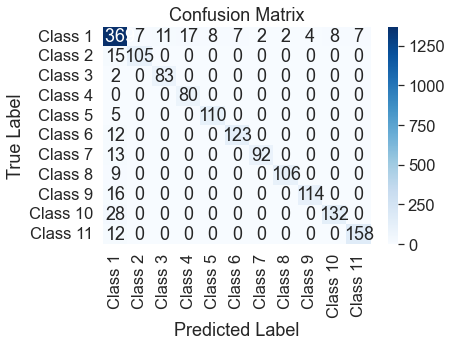

              precision    recall  f1-score      support
0.0            0.924375  0.949376  0.936709  1442.000000
1.0            0.937500  0.875000  0.905172   120.000000
2.0            0.882979  0.976471  0.927374    85.000000
3.0            0.824742  1.000000  0.903955    80.000000
4.0            0.932203  0.956522  0.944206   115.000000
5.0            0.946154  0.911111  0.928302   135.000000
6.0            0.978723  0.876190  0.924623   105.000000
7.0            0.981481  0.921739  0.950673   115.000000
8.0            0.966102  0.876923  0.919355   130.000000
9.0            0.942857  0.825000  0.880000   160.000000
10.0           0.957576  0.929412  0.943284   170.000000
accuracy       0.930373  0.930373  0.930373     0.930373
macro avg      0.934063  0.917977  0.923968  2657.000000
weighted avg   0.931987  0.930373  0.930181  2657.000000


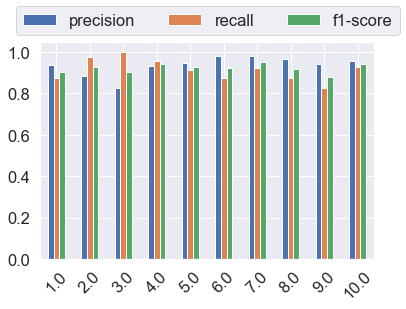

In [215]:
show(y_test, predicted_labels)

[[1511    6    8   16    8    3    0    0    4    0    6]
 [  17   91    0    0    0    0    0    0    0    0    0]
 [   3    0   70    0    0    0    0    0    0    0    0]
 [   0    0    0   68    0    0    0    0    0    0    0]
 [   9    0    0    0   94    0    0    0    0    0    0]
 [  14    0    0    0    0  109    0    0    0    0    0]
 [  14    0    0    0    0    0   79    0    0    0    0]
 [   9    0    0    0    0    0    0   94    0    0    0]
 [  21    0    0    0    0    0    0    0   97    0    0]
 [  32    0    0    0    0    0    0    0    0  116    0]
 [  12    0    0    0    0    0    0    0    0    0  146]]


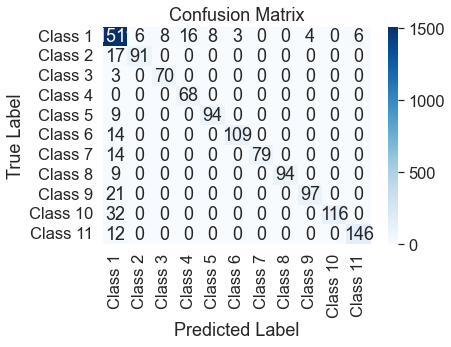

              precision    recall  f1-score      support
0.0            0.920219  0.967350  0.943196  1562.000000
1.0            0.938144  0.842593  0.887805   108.000000
2.0            0.897436  0.958904  0.927152    73.000000
3.0            0.809524  1.000000  0.894737    68.000000
4.0            0.921569  0.912621  0.917073   103.000000
5.0            0.973214  0.886179  0.927660   123.000000
6.0            1.000000  0.849462  0.918605    93.000000
7.0            1.000000  0.912621  0.954315   103.000000
8.0            0.960396  0.822034  0.885845   118.000000
9.0            1.000000  0.783784  0.878788   148.000000
10.0           0.960526  0.924051  0.941935   158.000000
accuracy       0.931502  0.931502  0.931502     0.931502
macro avg      0.943730  0.896327  0.916101  2657.000000
weighted avg   0.934505  0.931502  0.930892  2657.000000


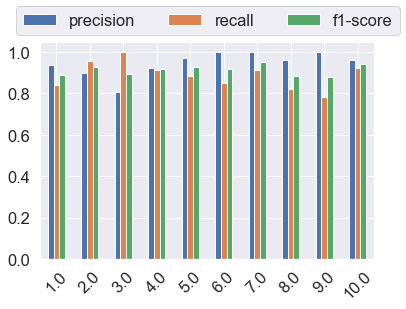

In [216]:
show(y_test_5,predicted_labels_5)

In [28]:
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()
#TEST 

ValueError: cannot reshape array of size 29227 into shape (2657,)

In [29]:
# make a prediction
yhat = model.predict(test_test).reshape(1204)#.reshape(2657)
#rmse = math.sqrt(mean_squared_error(yhat, test_y))
#print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
#plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

#TEST 

ValueError: cannot reshape array of size 13244 into shape (1204,)

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 200
分類器的準確率為： 0.9303726006774558
分類器的錯誤筆數為： 185
Test RMSE: 1.744


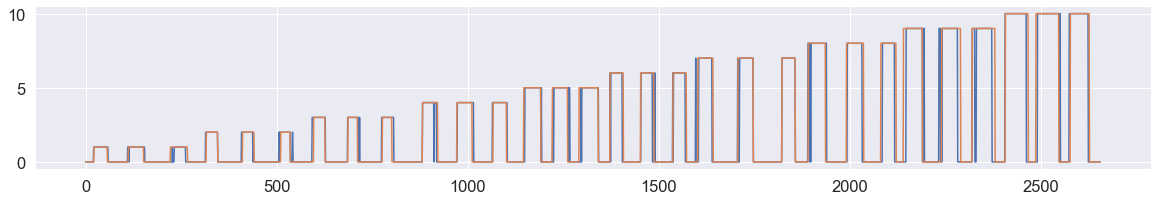

In [207]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

In [41]:
def fiveway(arr):
    # 将五个状态的元素分别设为 1、2、3、4、5
    arr_states = np.zeros((len(arr), 10), dtype=int)
    for i in range(1, 11):
        arr_states[:, i-1][arr == i] = 1
        
    # 使用卷积操作查找连续的五个相同的元素
    kernel = np.ones(5)
    result_states = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=0, arr=arr_states)


    # 将大于等于 5 的元素视为当前状态，其他元素视为 0
    result_states[result_states < 5] = 0
    idx = np.where(result_states == 5)

    # 使用布尔索引找到对应的行和列
    row_idx = idx[0]
    col_idx = idx[1]

    # 将值为 5 的位置改成对应的列号
    result_states[row_idx, col_idx] = col_idx + 1

    # 将所有状态的结果相加得到总结果
    result = np.sum(result_states, axis=1)

    # 输出结果
    return(result)


{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 200
分類器的準確率為： 0.931501693639443
分類器的錯誤筆數為： 182
Test RMSE: 1.718


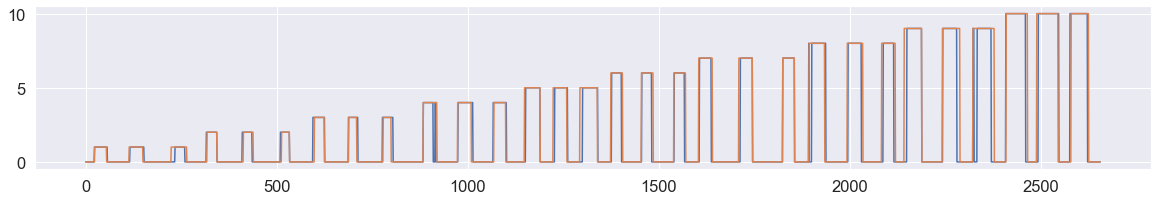

In [211]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)
predicted_labels_5 = fiveway(predicted_labels)
y_test_5 = fiveway(y_test)

rmse = math.sqrt(mean_squared_error(predicted_labels_5, y_test_5))

# 計算分類器的準確率
accuracy = accuracy_score(y_test_5, predicted_labels_5)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test_5 != predicted_labels_5)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels_5)
plt.plot(y_test_5)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()
#show(y_test_5,predicted_labels_5)

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 25
分類器的準確率為： 0.9258562288295069
分類器的錯誤筆數為： 197
Test RMSE: 1.736


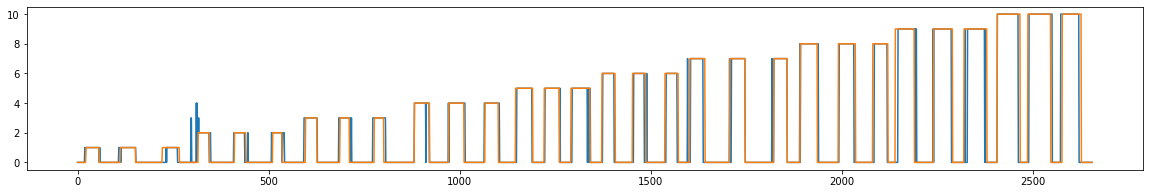

In [71]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 50
分類器的準確率為： 0.931501693639443
分類器的錯誤筆數為： 182
Test RMSE: 1.750


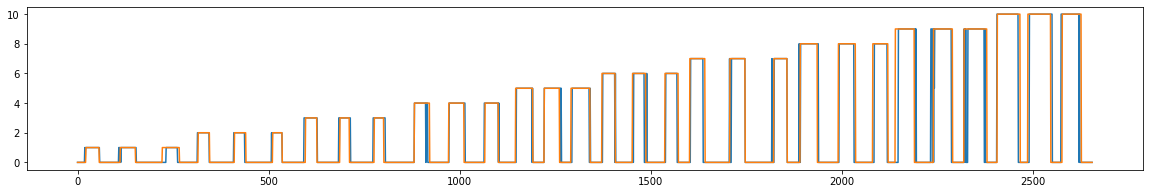

In [77]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 50
分類器的準確率為： 0.923974407226195
分類器的錯誤筆數為： 202
Test RMSE: 1.755


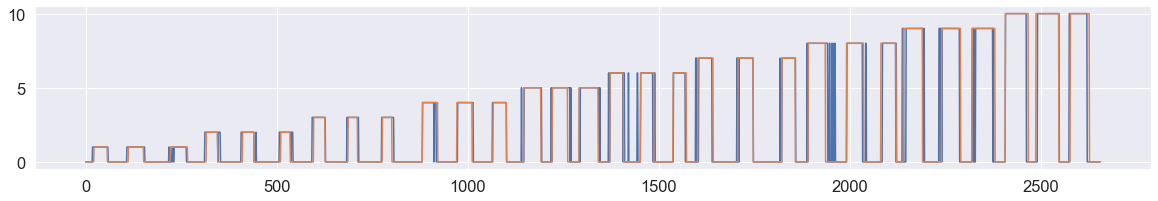

In [45]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 100
分類器的準確率為： 0.9284907790741438
分類器的錯誤筆數為： 190
Test RMSE: 1.737


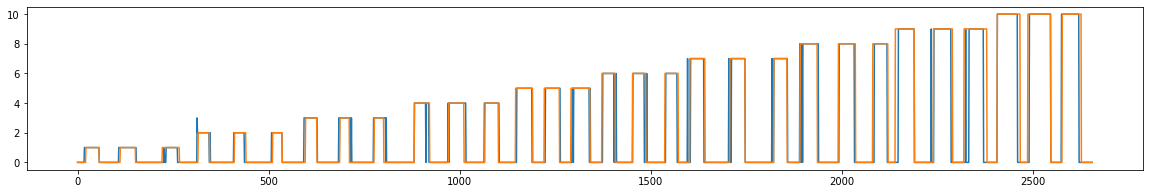

In [80]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 100
分類器的準確率為： 0.927738050432819
分類器的錯誤筆數為： 192
Test RMSE: 1.730


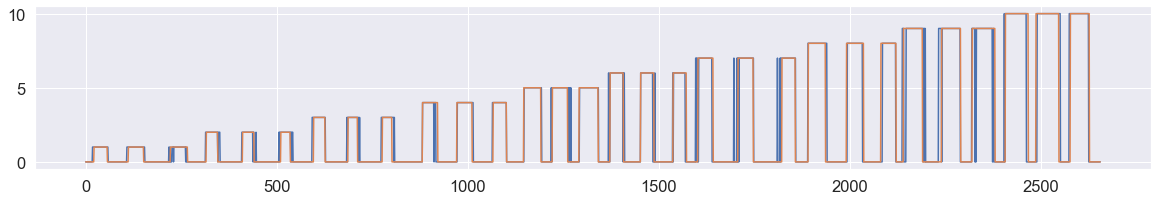

In [48]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 150
分類器的準確率為： 0.931501693639443
分類器的錯誤筆數為： 182
Test RMSE: 1.745


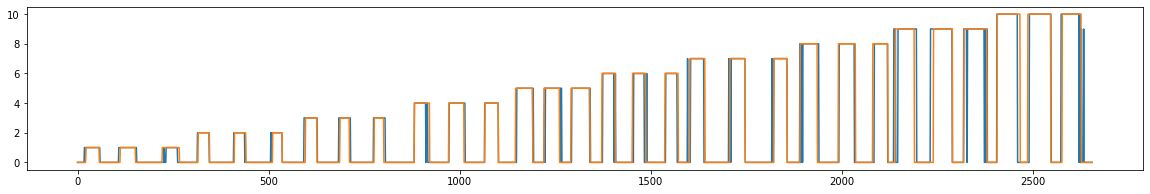

In [61]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 200
分類器的準確率為： 0.9198343996989086
分類器的錯誤筆數為： 213
Test RMSE: 1.814


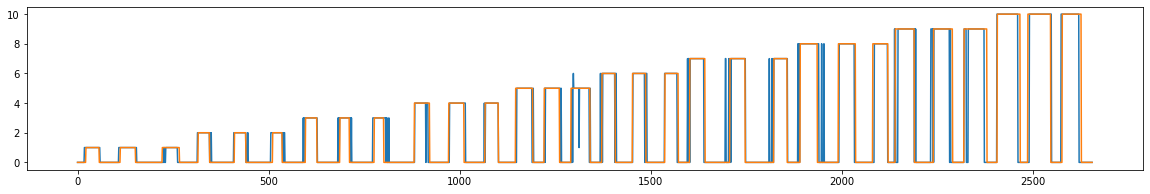

In [47]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 200
分類器的準確率為： 0.9322544222807678
Test RMSE: 1.663


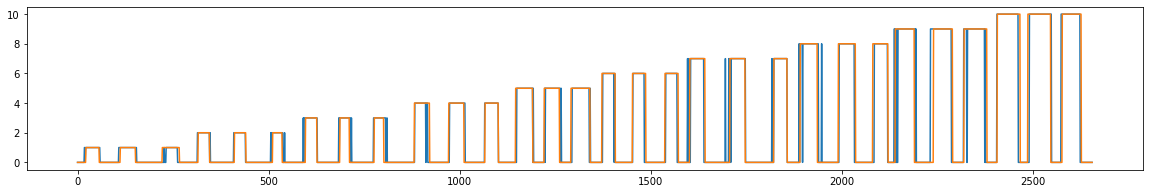

In [26]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 225
分類器的準確率為： 0.9224689499435453
分類器的錯誤筆數為： 206
Test RMSE: 1.824


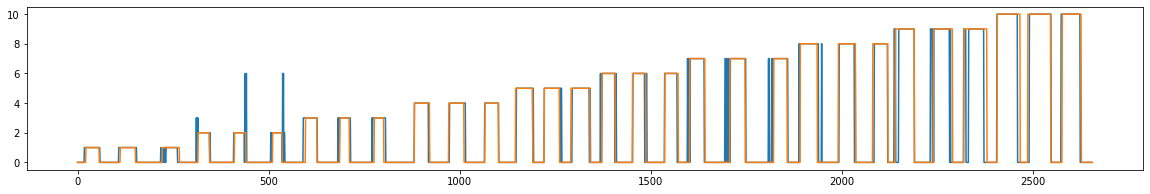

In [49]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 250
分類器的準確率為： 0.9288671433948061
分類器的錯誤筆數為： 189
Test RMSE: 1.741


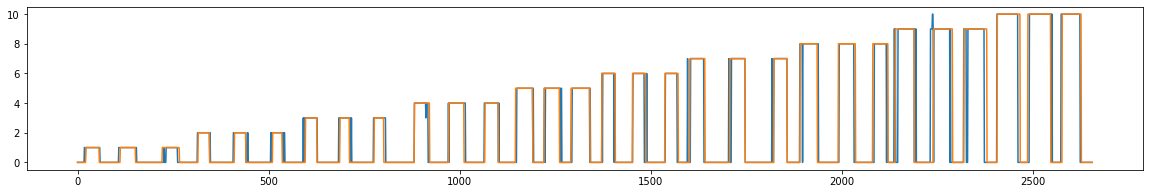

In [44]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 275
分類器的準確率為： 0.9247271358675198
分類器的錯誤筆數為： 200
Test RMSE: 1.787


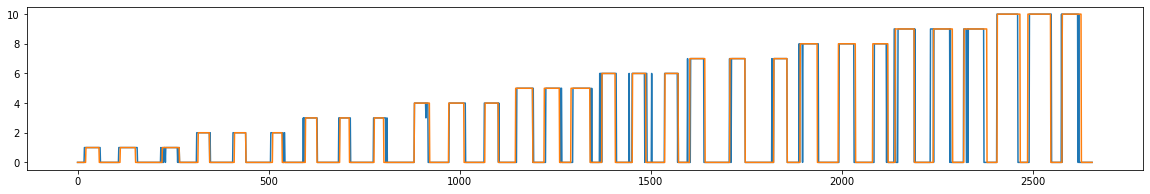

In [55]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 300
分類器的準確率為： 0.9235980429055326
分類器的錯誤筆數為： 203
Test RMSE: 1.833


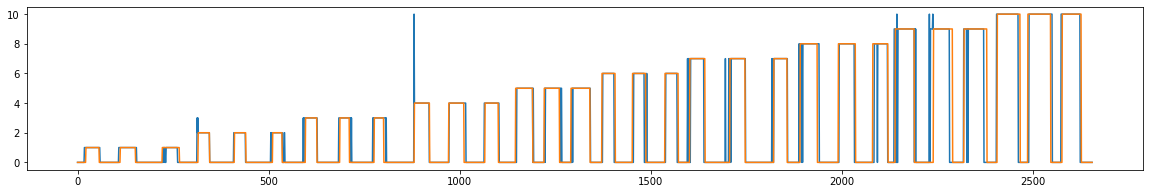

In [52]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 500
分類器的準確率為： 0.9160707564922845
分類器的錯誤筆數為： 223
Test RMSE: 1.877


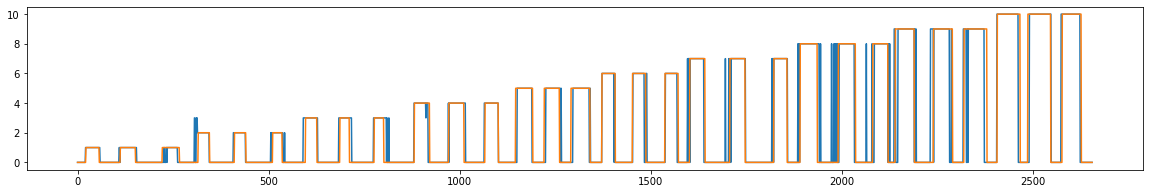

In [41]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 150, 'neurons2': 100, 'neurons3': 50} 
 epochs: 1500
分類器的準確率為： 0.9194580353782461
分類器的錯誤筆數為： 214
Test RMSE: 1.906


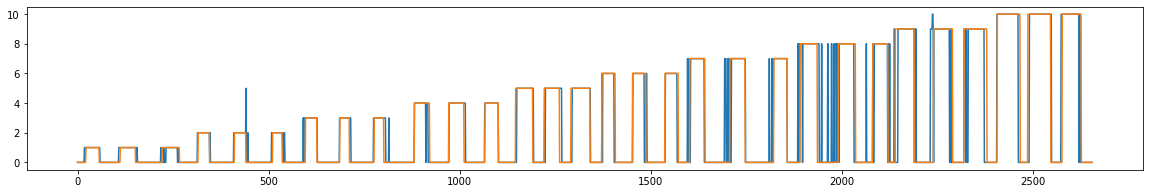

In [68]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

# 計算分類器的错误数量
error_count = np.count_nonzero(y_test != predicted_labels)
print("分類器的錯誤筆數為：", error_count)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 100, 'neurons2': 100, 'neurons3': 100} 
 epochs: 50
分類器的準確率為： 0.9292435077154686
Test RMSE: 1.735


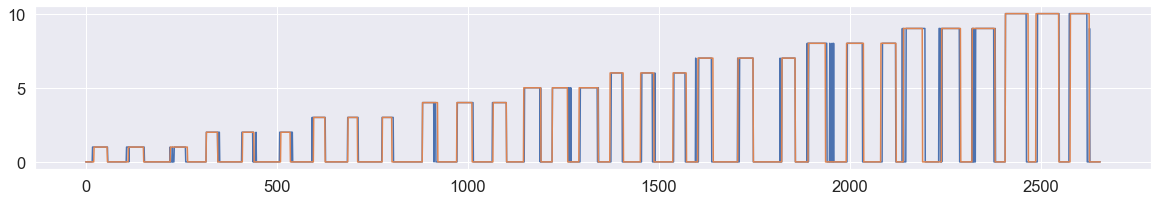

In [194]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 100, 'neurons2': 100, 'neurons3': 100} 
 epochs: 250
分類器的準確率為： 0.9273616861121565
Test RMSE: 1.787


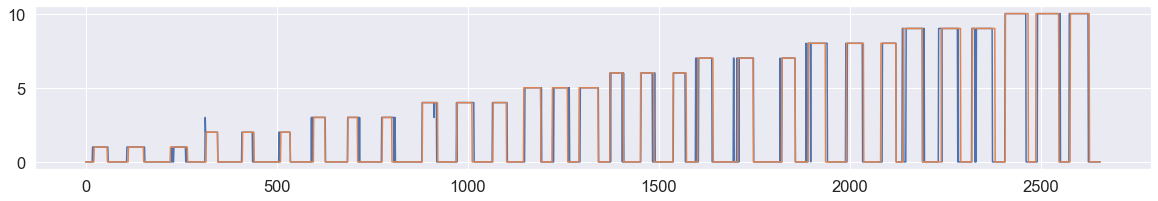

In [191]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 100, 'neurons2': 100, 'neurons3': 100} 
 epochs: 125
分類器的準確率為： 0.918328942416259
Test RMSE: 1.826


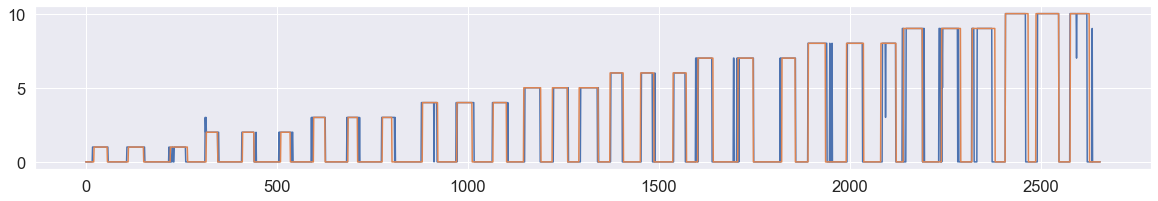

In [188]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 100, 'neurons2': 100, 'neurons3': 100} 
 epochs: 175
分類器的準確率為： 0.9266089574708317
Test RMSE: 1.778


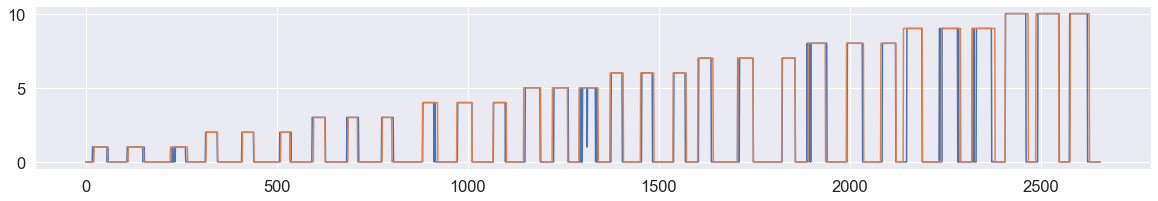

In [180]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 100, 'neurons2': 100, 'neurons3': 100} 
 epochs: 200
分類器的準確率為： 0.922092585622883
Test RMSE: 1.849


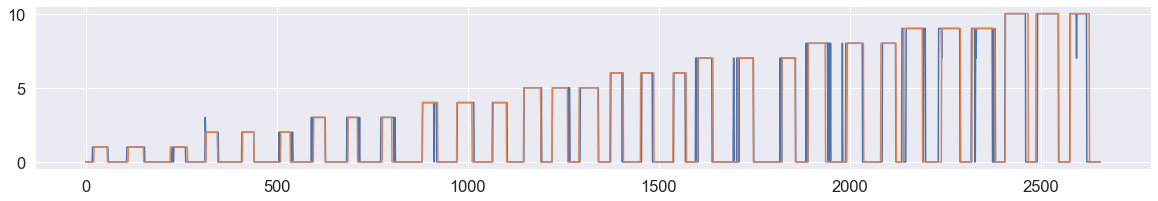

In [176]:
print(grid_result,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 100, 'neurons2': 100, 'neurons3': 100} 
 epochs: 150
分類器的準確率為： 0.9303726006774558
Test RMSE: 1.767


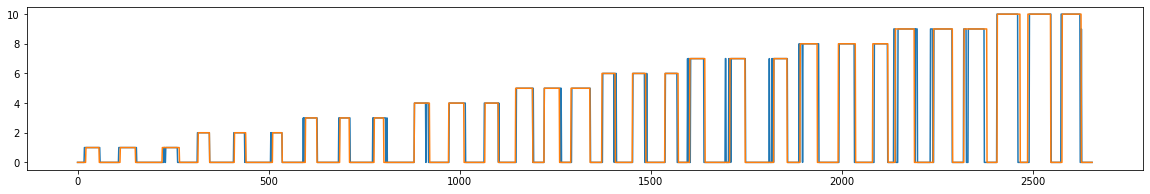

In [54]:
print(grid_result.best_params_,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))

# 計算分類器的準確率
accuracy = accuracy_score(y_test, predicted_labels)
print("分類器的準確率為：", accuracy)

print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 100, 'neurons2': 100, 'neurons3': 100} 
 epochs: 100
Test RMSE: 1.690


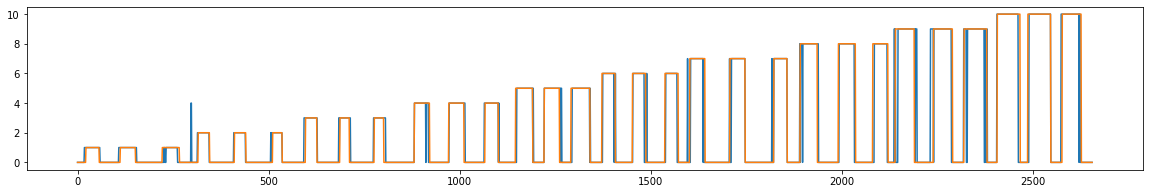

In [49]:
print(grid_result.best_params_,'\n epochs:',epochs)# softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 100, 'neurons2': 100, 'neurons3': 100} 
 epochs: 50
Test RMSE: 1.770


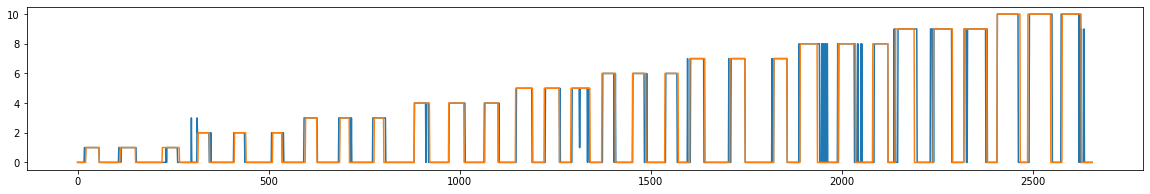

In [46]:
print(grid_result.best_params_,'\n epochs:',epochs)# 50迭代   softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 100, 'neurons2': 100, 'neurons3': 100}
Test RMSE: 1.751


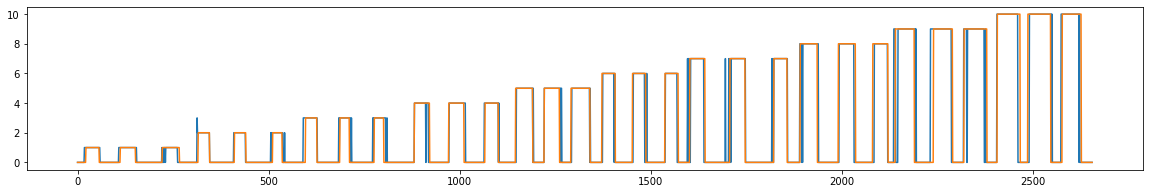

In [36]:
print(grid_result.best_params_)#  200迭代   softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 100, 'neurons2': 100, 'neurons3': 100}
Test RMSE: 1.827


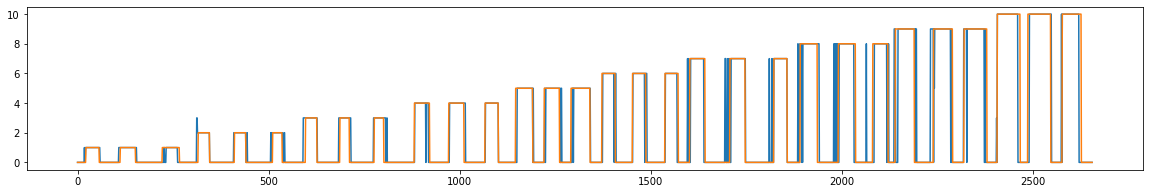

In [34]:
print(grid_result.best_params_)#  1000迭代   softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 100, 'neurons2': 100, 'neurons3': 100}
Test RMSE: 1.791


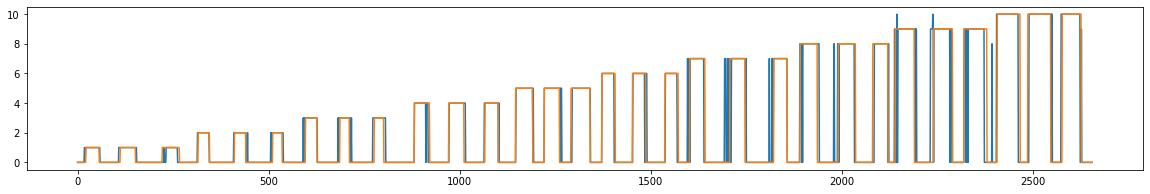

In [32]:
print(grid_result.best_params_)#  1500迭代   softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'neurons1': [300], 'neurons2': [200], 'neurons3': [100], 'dropout_rate': [0.3], 'learning_rate': [0.001]}
Test RMSE: 1.997


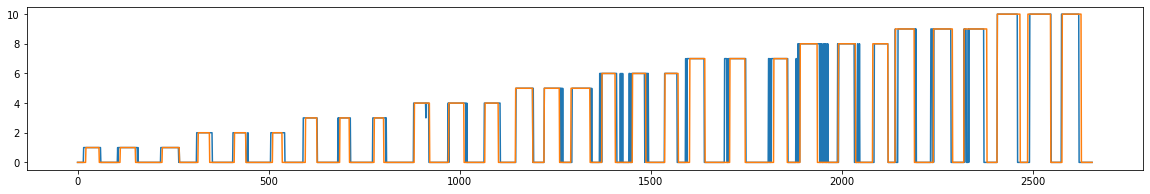

In [144]:
print(param_grid)#1634min  50迭代   softmax
yhat = model.predict(test_X)

# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)

rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'neurons1': [300], 'neurons2': [200], 'neurons3': [100], 'dropout_rate': [0.3], 'learning_rate': [0.001]}
Test RMSE: 1.840


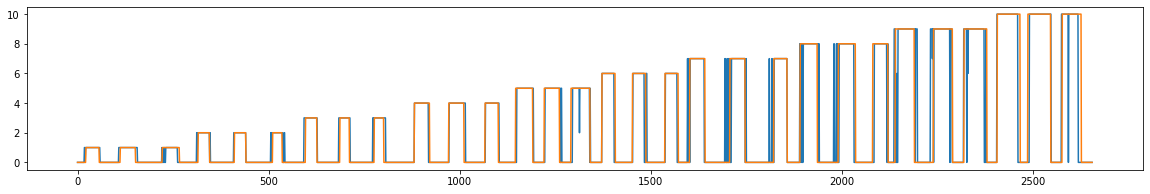

In [137]:
print(param_grid)#1634min  1500迭代   softmax
yhat = model.predict(test_X)
# 將概率最大的元素作為預測類別
predicted_labels = np.argmax(yhat, axis=1)
rmse = math.sqrt(mean_squared_error(predicted_labels, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(predicted_labels)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'neurons1': [300], 'neurons2': [200], 'neurons3': [100], 'dropout_rate': [0.3], 'learning_rate': [0.001]}
Test RMSE: 17.711


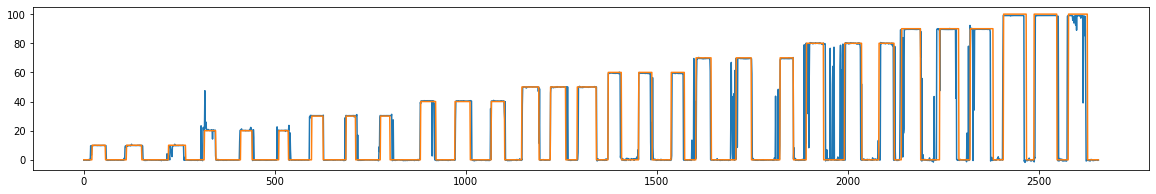

In [63]:
print(param_grid)#1634min  1500迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 100, 'neurons2': 200, 'neurons3': 300}
Test RMSE: 17.643


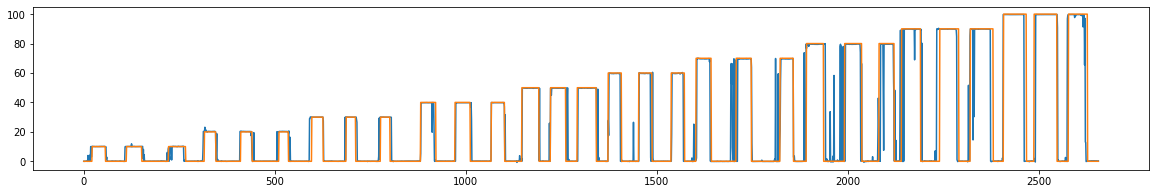

In [97]:
print(grid_result.best_params_)#1634min  2000迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'neurons1': 100, 'neurons2': 200, 'neurons3': 300, 'dropout_rate': 0.3, 'learning_rate': 0.001}
Test RMSE: 17.912


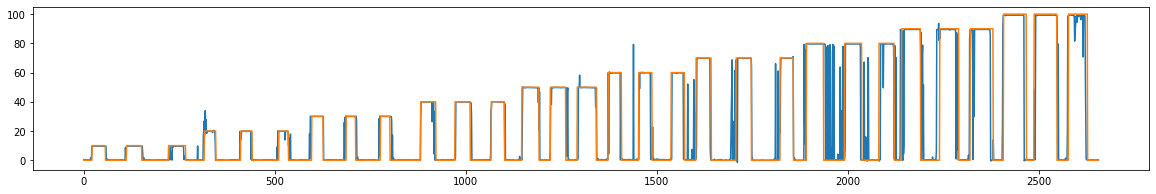

In [46]:
print(grid_result)#1634min  1750迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 100, 'neurons2': 200, 'neurons3': 300}
Test RMSE: 17.470


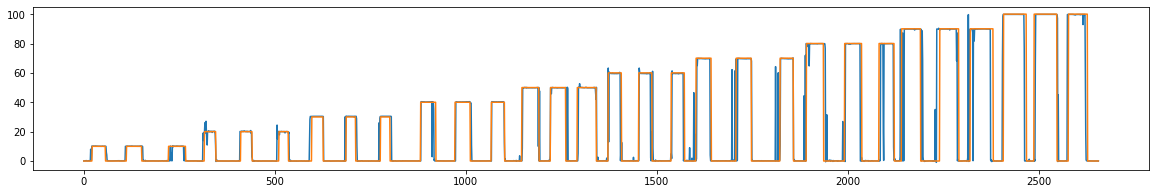

In [91]:
print(grid_result.best_params_)#1634min  1500迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'neurons1': 100, 'neurons2': 200, 'neurons3': 300, 'dropout_rate': 0.3, 'learning_rate': 0.001}
Test RMSE: 17.370


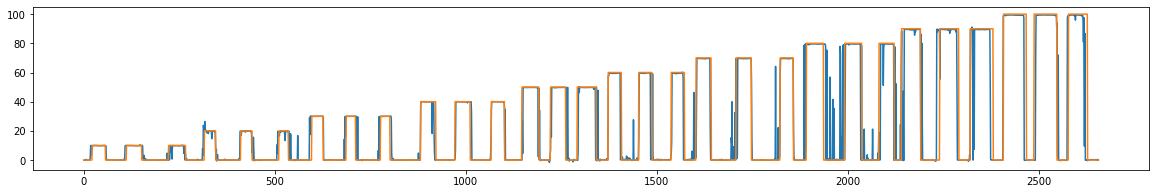

In [43]:
print(grid_result)#1634min  1250迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

{'dropout_rate': 0.3, 'learning_rate': 0.001, 'neurons1': 100, 'neurons2': 200, 'neurons3': 300}
Test RMSE: 16.650


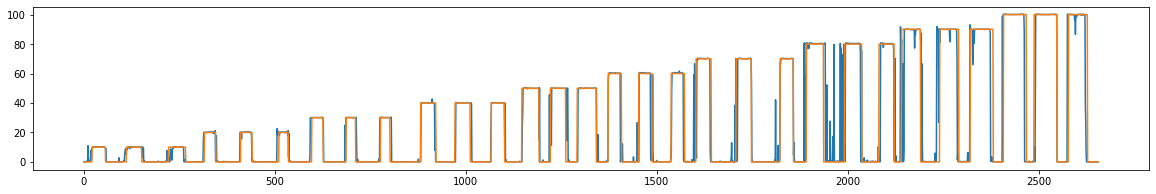

In [94]:
print(grid_result.best_params_)#1634min  1000迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

In [ ]:
#1000神經元 500神經元  250神經元 2000迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

Test RMSE: 17.700


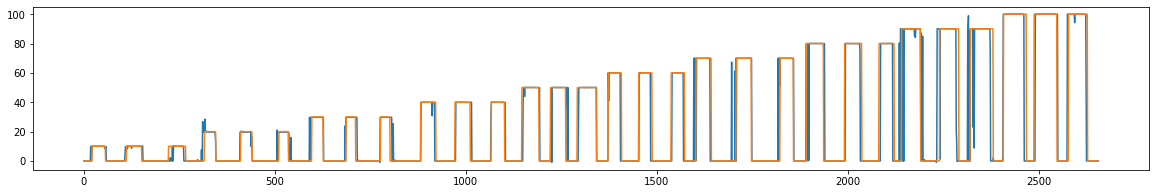

In [165]:
#100神經元 50神經元  25神經元 2000迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

Test RMSE: 17.037


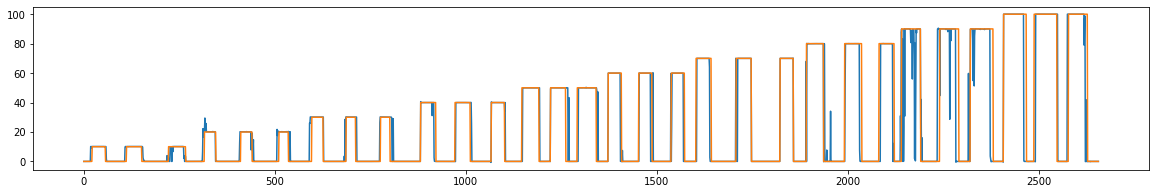

In [162]:
#100神經元 50神經元  25神經元 1500迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

Test RMSE: 17.234


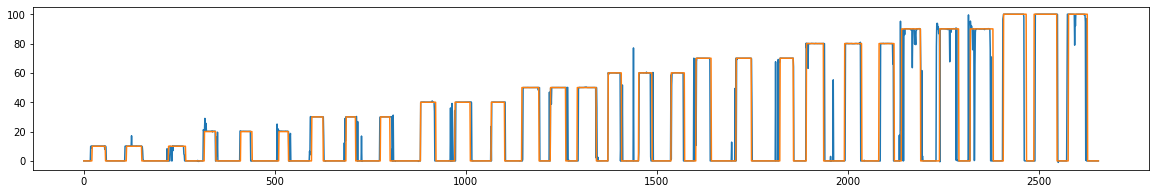

In [159]:
#100神經元 50神經元  25神經元 1000迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

Test RMSE: 17.306


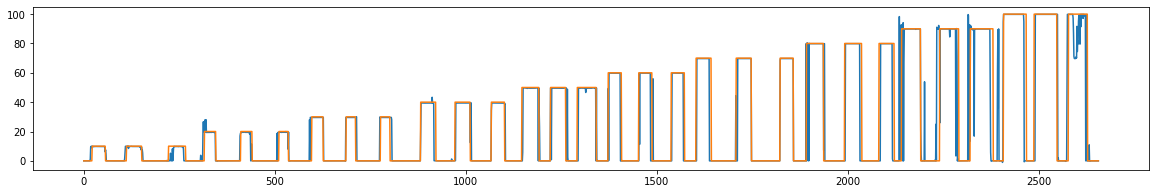

In [156]:
#1000神經元 500神經元  250神經元 1000迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

Test RMSE: 17.806


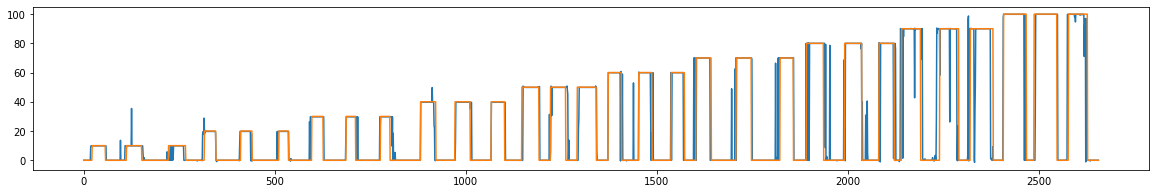

In [153]:
#1000神經元 500神經元  250神經元 1500迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

Test RMSE: 17.018


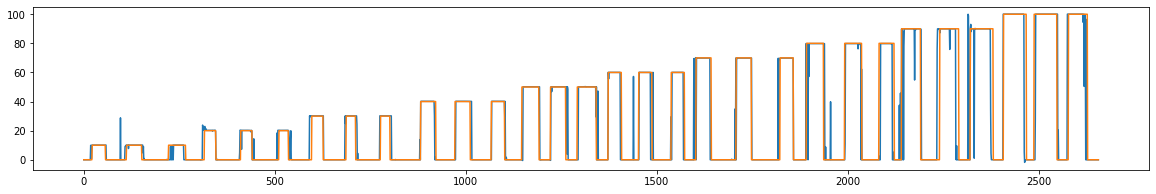

In [150]:
#1000神經元 500神經元  250神經元 2000迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

Test RMSE: 16.286


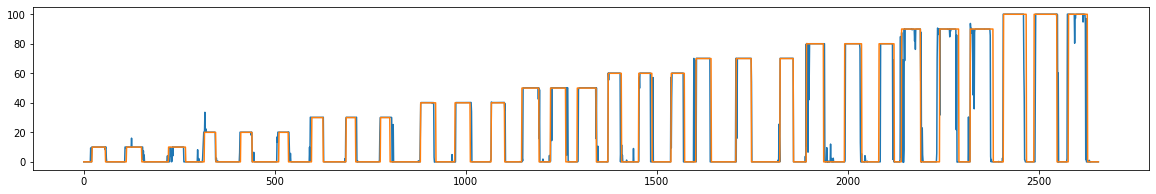

In [26]:
#500神經元  100神經元 2000迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()


Test RMSE: 16.555


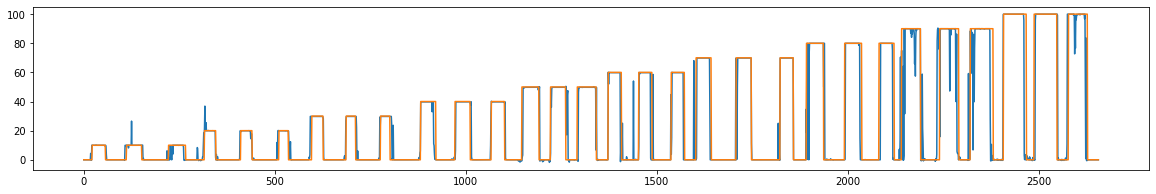

In [23]:
#500神經元  100神經元 1000迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()


Test RMSE: 16.981


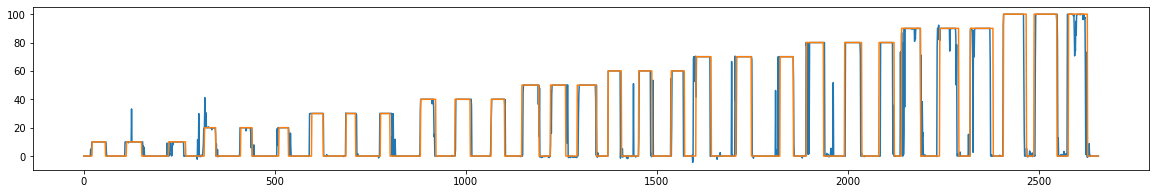

In [20]:
#500神經元  100神經元 1500迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

Test RMSE: 17.103


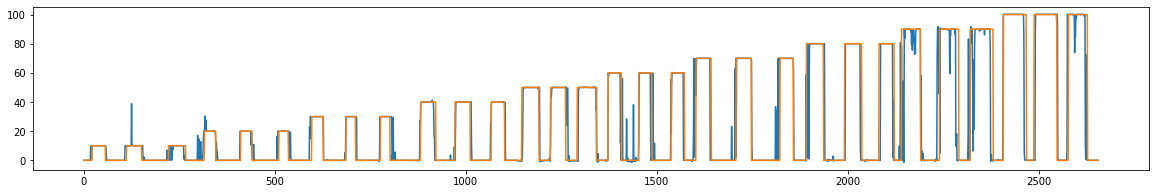

In [29]:
#500神經元  250神經元 1000迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()


Test RMSE: 17.127


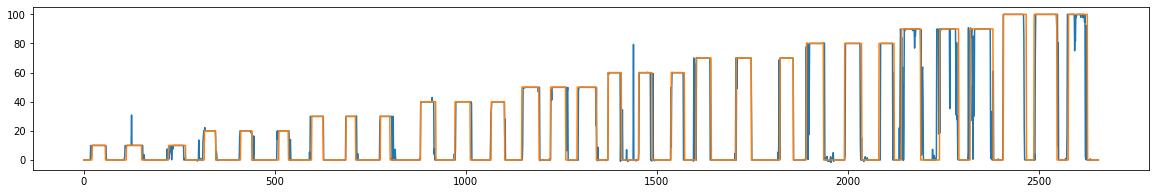

In [32]:
#500神經元  250神經元 1500迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

Test RMSE: 16.619


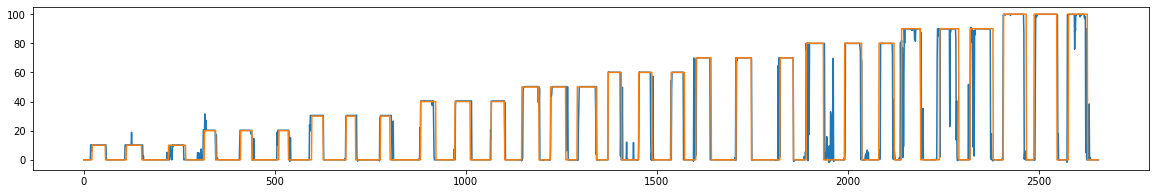

In [20]:
#1000神經元  500神經元 1500迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()


Test RMSE: 16.804


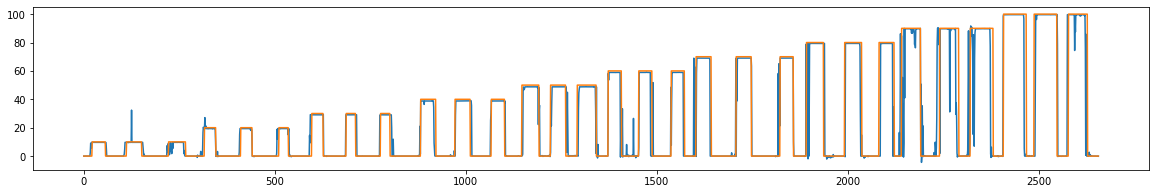

In [23]:
#1000神經元  500神經元 1000迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

Test RMSE: 16.545


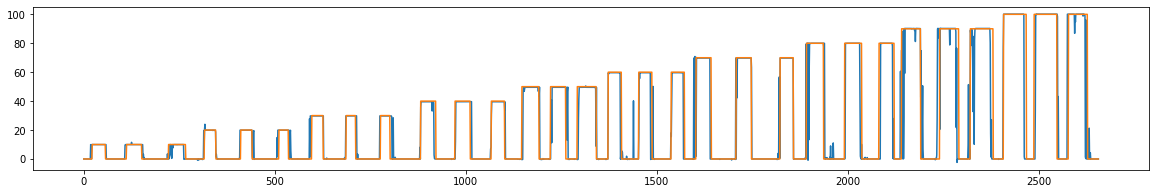

In [26]:
#1000神經元  500神經元 2000迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()

Test RMSE: 16.443


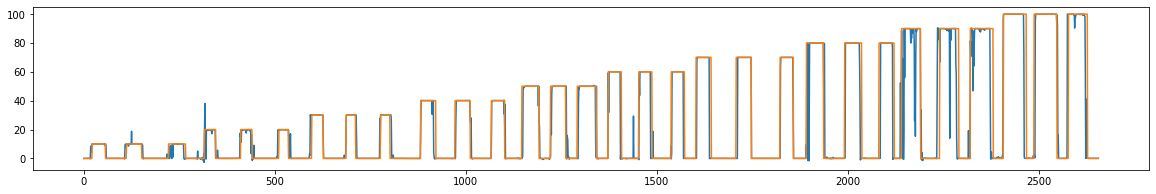

In [139]:
#250神經元  50神經元 1000迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()


Test RMSE: 17.099


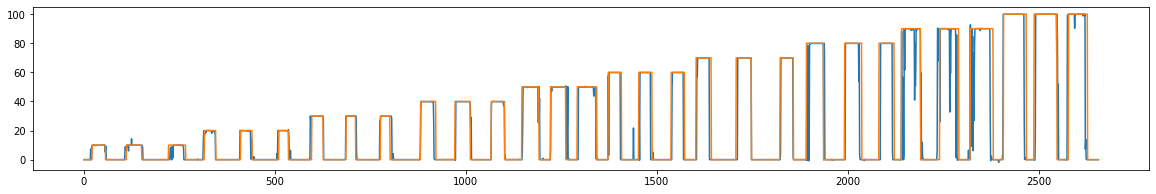

In [142]:
#250神經元  50神經元 1500迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()


Test RMSE: 16.529


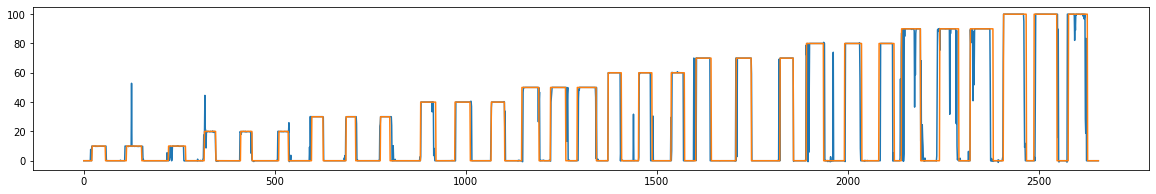

In [146]:
#250神經元  50神經元 2000迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()


In [ ]:
#500神經元  100神經元 1000迭代  
# make a prediction
yhat = model.predict(test_X).reshape(2657)#.reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=3,color = 'red' , linestyle="-.")
plt.show()


Test RMSE: 15.296


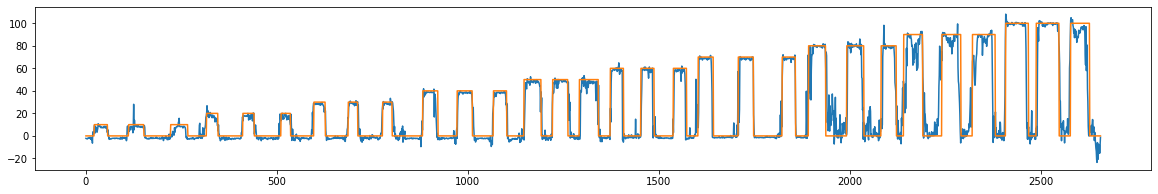

In [61]:
# make a prediction
yhat = model.predict(test_X).reshape(2657)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
#plt.axhline(y=70 ,color = 'red' , linestyle="-.")
plt.show()

把每次動作分別開來，打亂後再進行判斷

In [24]:
number

11

11

In [58]:
for i in range(int(number/10)-1):
    #print(i,'#-------------------------------------------------------------------')
    yhat = model.predict(tes_X[i])#locals()['test_'+str(i)]
    #plt.figure(figsize=(20, 3))
    #plt.plot(yhat)
    #plt.plot(tes_y[i])
    #plt.show()
    
    n_test = int(len(tes_X[i])/3)
    test_x0= tes_X[i][:n_test, :]
    test_x1 = tes_X[i][n_test:n_test*2, :]
    test_x2 = tes_X[i][n_test*2:, :]

    test_y0 = tes_y[i][:n_test]
    test_y1 = tes_y[i][n_test:n_test*2]
    test_y2 = tes_y[i][n_test*2:]

    for j in range(3):
        yhat = model.predict(locals()['test_x'+str(j)])#locals()['test_'+str(i)]
        #plt.figure(figsize=(20, 3))
        #plt.plot(yhat)
        #plt.plot(locals()['test_y'+str(j)])
        #plt.show()
        locals()['test_x'+str(i)+str(j)] = locals()['test_x'+str(j)]
        locals()['test_y'+str(i)+str(j)] = locals()['test_y'+str(j)]

In [59]:
from random import shuffle
test_list = []
for i in range(8):
    for j in range(3):
        test_list.append(str(i)+str(j))
shuffle(test_list)#隨機打亂順序
test_x = locals()['test_x'+test_list[0]]
test_Y = locals()['test_y'+test_list[0]] 
for i in test_list[1:]:
    test_x = np.concatenate((test_x,locals()['test_x'+i]))
    test_Y = np.concatenate((test_Y,locals()['test_y'+i]))

Test RMSE: 11.126


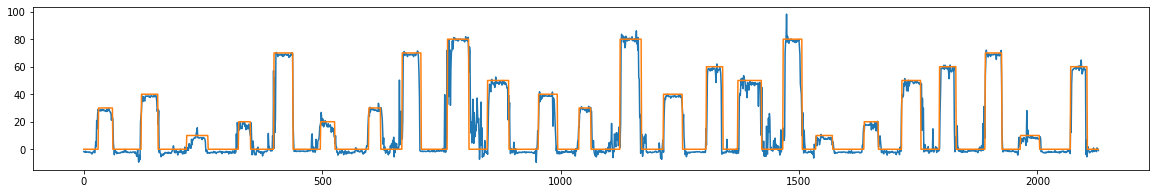

In [60]:
# make a prediction
yhat = model.predict(test_x)
rmse = math.sqrt(mean_squared_error(yhat, test_Y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_Y)
#plt.axhline(y=3 ,color = 'red' , linestyle="-.")
plt.show()

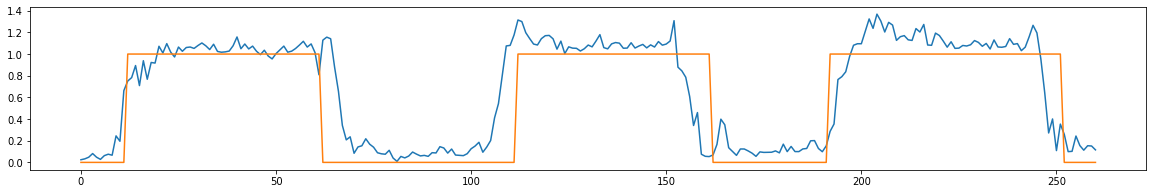

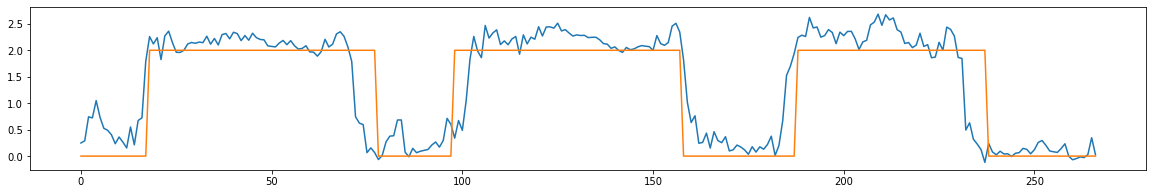

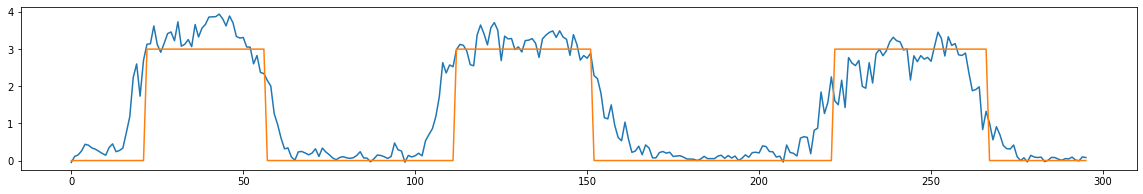

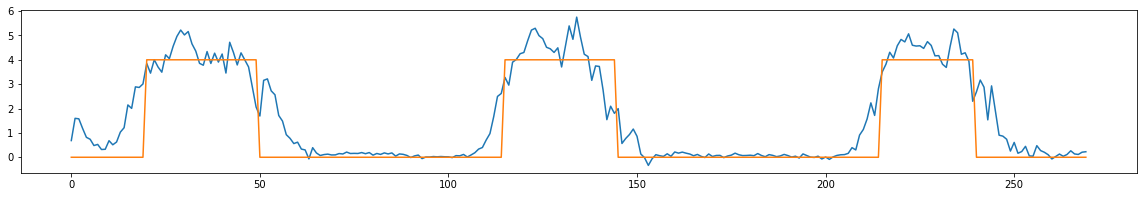

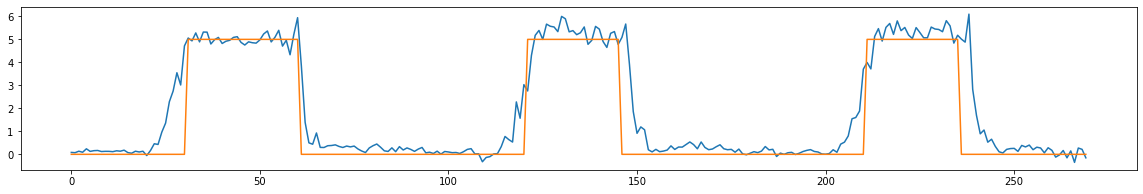

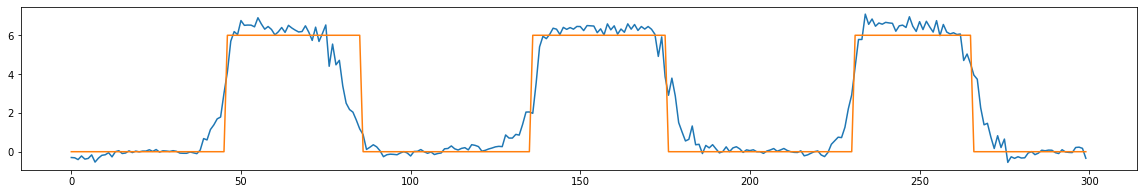

IndexError: list index out of range

In [98]:
for i in range(8):
    yhat = model.predict(tes_X[i])#locals()['test_'+str(i)]
    plt.figure(figsize=(20, 3))
    plt.plot(yhat)
    plt.plot(tes_y[i])
    #plt.axhline(y=3 ,color = 'red' , linestyle="-.")
    plt.show()

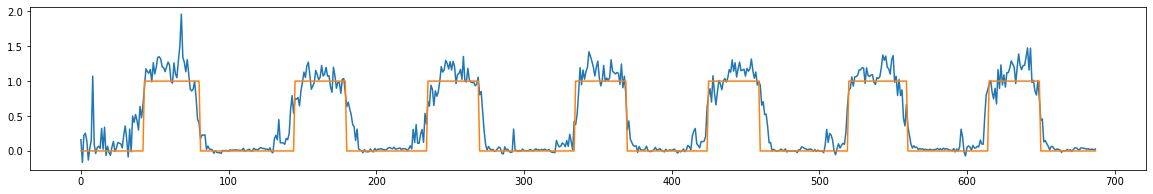

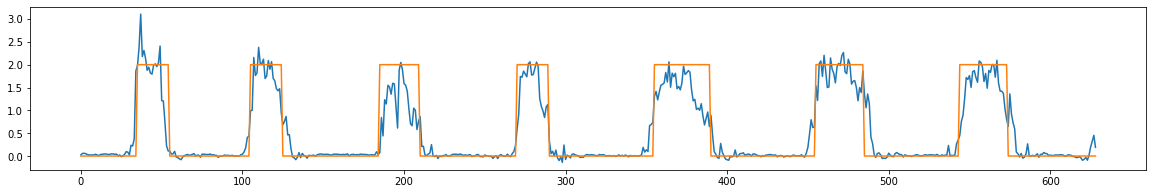

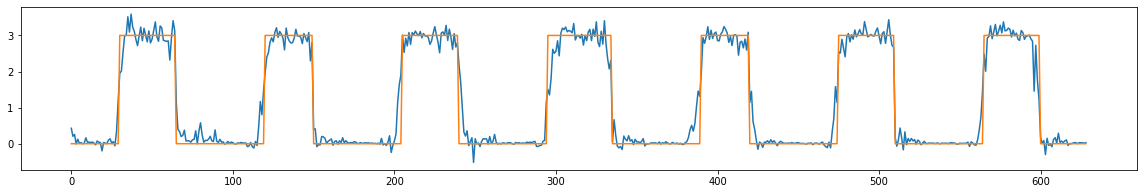

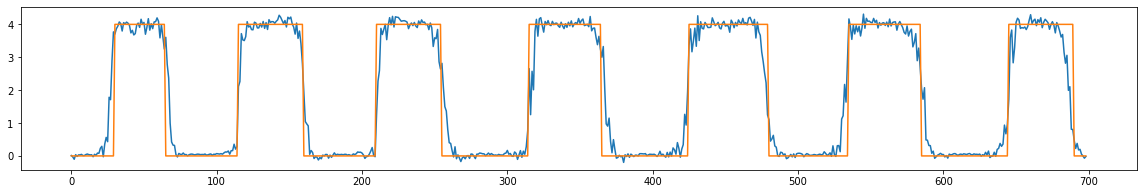

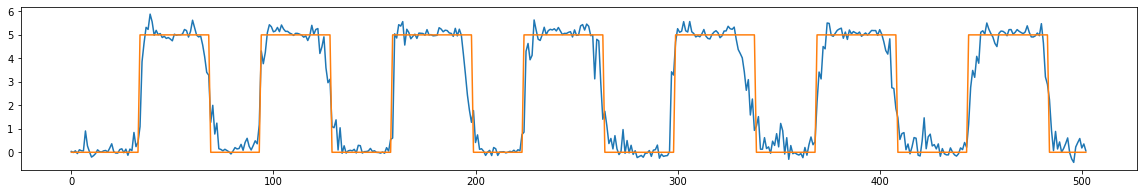

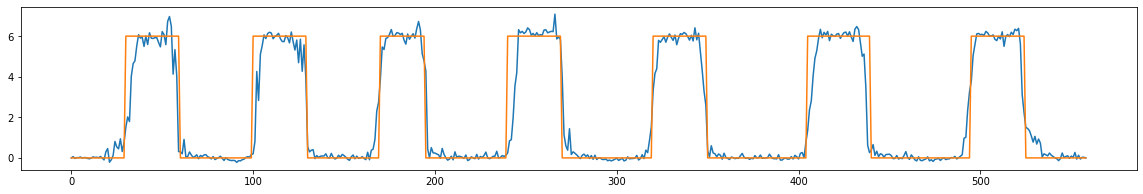

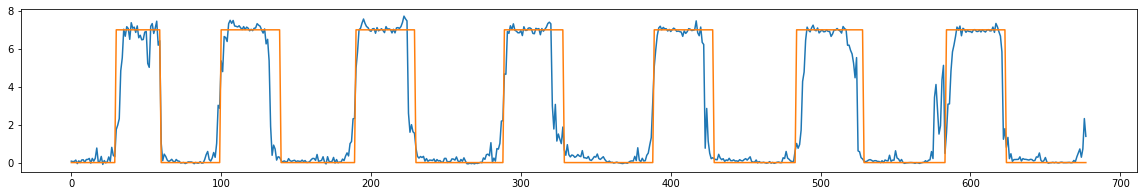

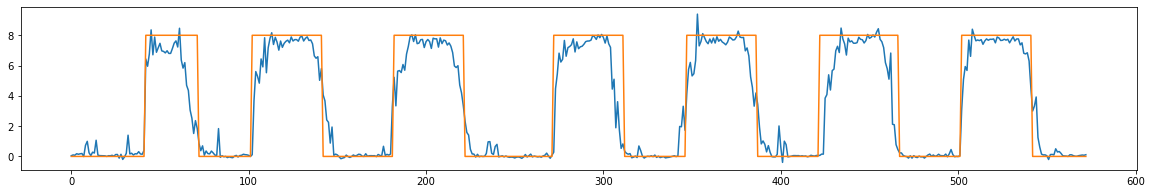

In [122]:
for i in range(8):
    yhat = model.predict(tra_X[i])#locals()['test_'+str(i)]
    plt.figure(figsize=(20, 3))
    plt.plot(yhat)
    plt.plot(tra_y[i])
    #plt.axhline(y=3 ,color = 'red' , linestyle="-.")
    plt.show()

In [28]:
yhat = model.predict(test_3)
#rmse = math.sqrt(mean_squared_error(yhat, test_y))
#print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
#plt.plot(test_y)
#plt.axhline(y=3 ,color = 'red' , linestyle="-.")
plt.show()

NameError: name 'test_3' is not defined

In [63]:
values = reframed.values
n_train_hours = int(len(values)*0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:,:-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
return(train_X ,test_X,train_y,test_y)

2135

In [57]:
test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

ValueError: cannot reshape array of size 283955 into shape (2135,1,1)

In [ ]:
yhat_l = pd.DataFrame(yhat)

In [ ]:
yhat_l[(yhat_l[0]>1.7)&(yhat_l[0]<2.1)]

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(yhat_l[(yhat_l[0]>1.8)&(yhat_l[0]<2.1)], linewidth="2", markersize="10", marker="o")
plt.plot(test_y)
plt.axhline(y=1.8 ,color = 'red' , linestyle="-.")
plt.show()

In [ ]:
df_drop = dataset.drop(['right_1','left_1','wave_1','right_2','left_2','wave_2','right_3','left_3','wave_3'],axis=1)#,'RElbow_3','RWrist_3'

In [ ]:
df_drop = dataset_rl.drop(['wave'],axis=1)

In [ ]:
#dataset = pd.read_csv("D:/openpose_data/UT_Kinect/RGB/s01_e01_all_標記walk.csv") #读取数据
#dataset.columns = ["pm25", "dew",  "temp", "press", "wnd_dir", "wnd_spd", "snow", "rain"] #重命名表头
values = df_drop.values #数值特征变量
values


正規化----------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# ensure all data is float
values = values.astype('float32')
# normalize features 歸一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[range(len(list(df_drop)),len(list(df_drop))*2)]], axis=1, inplace=True)
print(reframed.head())

In [ ]:
test1 = scaler.inverse_transform(scaled)#規一化還原成原本數值
test1 

In [ ]:
test1 = scaler.inverse_transform(scaled)

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = int(len(values)*0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:,:-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(500, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=144, validation_data=(test_X, test_y), verbose=2, shuffle=False)#False
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
'''
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
'''

In [ ]:
# make a prediction
yhat = model.predict(test_X)

In [ ]:
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
plt.show()

In [ ]:
yhat[yhat>0.7] = 1
yhat[(yhat>0.4) & (yhat<0.7) ] = 0.5
yhat[yhat<0.5] = 0

In [ ]:
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(test_y)
plt.show()

In [ ]:
test = values[n_train_hours:, :]

In [ ]:
df_drop['方向'][n_train_hours:].reset_index(drop=True)

In [ ]:
yhat_p = pd.concat([pd.DataFrame(yhat,columns=['yhat']),df_drop['方向'][n_train_hours:].reset_index(drop=True)],axis= 1)

In [ ]:
yhat_p['yp'] = 0
yhat_p['yp'][(yhat_p['yhat']>0.5)&(yhat_p['方向'] == -1)]=0.5
yhat_p['yp'][(yhat_p['yhat']>0.5)&(yhat_p['方向'] == 1)]=1

In [ ]:
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat_p['yp'])
plt.plot(test_y)
plt.show()

In [ ]:
test = np.reshape(test_X,(217, 25))

In [ ]:
test = pd.DataFrame(test)

In [ ]:
test

In [ ]:
yhat = model.predict(train_X)

In [ ]:
rmse = math.sqrt(mean_squared_error(yhat, train_y))
print('Test RMSE: %.3f' % rmse)
plt.figure(figsize=(20, 3))
plt.plot(yhat)
plt.plot(train_y)
plt.show()

範例

In [ ]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = int(len(reframed)*0.4)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

範例

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [ ]:
inv_yhat = scaler.inverse_transform(inv_yhat)

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
test_X 

In [ ]:
test_X [:, 1:]

In [ ]:
encoder = LabelEncoder() #编码
values[:,4] = encoder.fit_transform(values[:,4]) #将第4列编码
values = values.astype('float32') #使得所有数值类型都是float类型
scaler = MinMaxScaler(feature_range = (0, 1)) #0-1归一化
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1) #调用series_to_supervised函数将数据转为监督数据变成16列
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis= 1,inplace = True) 
values = reframed.values
n_train_hours = 365*24 #一年的小时数
train = values[:n_train_hours, :] #训练集
test = values[n_train_hours:, :] #测试集
train_x, train_y = train[:, :-1], train[:, -1] #训练集特征和标签 
test_x, test_y = test[:, :-1], test[:, -1] #测试集的特征和标签
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1])) #转为LSTM模型的输入格式（samples, timesteps, features）
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1])) #转为LSTM模型的输入格式（samples, timesteps, features）


In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape = (train_x.shape[0], train_x.shape[2]))) #8760*8
model.add(Dense(1))
model.compile(loss = "mae",optimizer= "adam")
history =model.fit(train_x, train_y, epochs= 50, batch_size=72, validation_data=(test_x, test_y), verbose=2, shuffle=False)
plt.figure()
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "test")
plt.legend()
plt.show()


In [ ]:
from keras.utils.vis_utils import plot_model
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt
from numpy import array
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler